In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("cybersimar08/drone-detection")

print("Path to dataset files:", path)
train_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "images")
train_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "labels")
valid_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "images")
valid_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "labels")
test_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "images")
test_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "labels")

100%|██████████| 499M/499M [00:25<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cybersimar08/drone-detection/versions/3


# Zadanie 1 - Uczenie klasyfikatora

1.   Zastosować wstępnie wytrenowaną sieć do uczenia tylko części klasyfikującej (ostatnie warstwy o połączeniach kompletnych).
2.   Zanalizować wyniki klasyfikacji.
3.   Zastąpić część klasyfikującą sieci przez SVM dla jądra liniowego,
kwadratowego i RBF.
4.   Zanalizować wyniki klasyfikacji. W szczególności, zbadać efekt
dopuszczenia błędnych klasyfikacji, porównać z wynikami 1a.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint

In [ ]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [ ]:
# Funkcja do wczytywania danych
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
def load_images_and_labels(image_dir, label_dir, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))
    images, labels = [], []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("RGB").resize(img_size)
        images.append(np.asarray(image))

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:  # Pusty plik = ptak
                class_id = 3
            else:
                class_id = int(lines[0].strip().split()[0])  # Samolot (0), dron (1), helikopter (2)
            labels.append(class_id)

    return np.array(images), np.array(labels)

In [ ]:
# Wczytywanie danych
train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir, IMG_SIZE)
valid_images, valid_labels = load_images_and_labels(valid_images_dir, valid_labels_dir, IMG_SIZE)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir, IMG_SIZE)

print(f"Obrazy treningowe: {len(train_images)}, walidacyjne: {len(valid_images)}, testowe: {len(test_images)}")

Obrazy treningowe: 10799, walidacyjne: 603, testowe: 596


Przykładowe dane z datasetu:


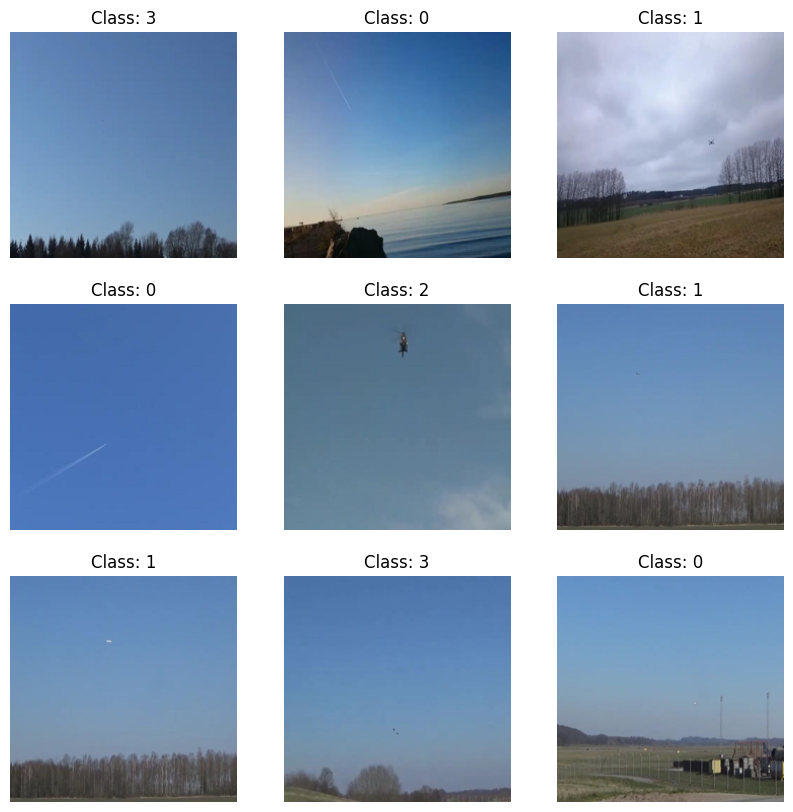

In [ ]:
print("Przykładowe dane z datasetu:")
plt.figure(figsize=(10, 10))
for i in range(9):
    image_no = randint(i+10, len(train_images))
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[image_no])
    plt.title(f"Class: {train_labels[image_no]}")
    plt.axis("off")
plt.show()

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def input_preprocess_train(image, label):
    image = img_augmentation(image)
    #label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
#valid_ds = valid_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
#test_ds = test_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

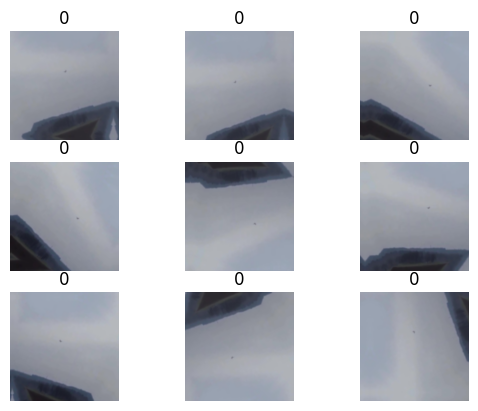

In [ ]:
# # Prezentacja danych po augmentacji
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image)
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title(int(label[0]))
        plt.axis("off")
    plt.show()

In [ ]:
# Wybór sieci
for images, labels in train_ds.take(1):
    input_shape = images[0].shape
    break

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Zamrożenie wag

In [ ]:
inputs = keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
#x = preprocess_input(inputs)
x = base_model(inputs, training=False)
# x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(50, activation='relu')(x)
# x = keras.layers.Dense(20, activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dense(1024, activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Rozpoczęcie treningu modelu (część A).")
EPOCHS = 10
history_a = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

Rozpoczęcie treningu modelu (część A).
Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.8570 - loss: 0.6485 - val_accuracy: 0.2985 - val_loss: 2.5526
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 129s 381ms/step - accuracy: 0.7172 - loss: 1.0702 - val_accuracy: 0.4511 - val_loss: 2.5390
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 145s 389ms/step - accuracy: 0.7475 - loss: 0.8980 - val_accuracy: 0.4975 - val_loss: 2.4447
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 129s 382ms/step - accuracy: 0.7832 - loss: 0.8052 - val_accuracy: 0.5224 - val_loss: 2.2889
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 143s 386ms/step - accuracy: 0.8086 - loss: 0.7390 - val_accuracy: 0.5539 - val_loss: 2.0893
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 140s 381ms/step - accuracy: 0.8175 - loss: 0.6742 - val_accuracy: 0.5638 - val_loss: 2.0495
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 386ms/step - accuracy: 0.8236 - loss: 0.6510 - val_accuracy: 0.5721 - val_loss: 1.9702
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━

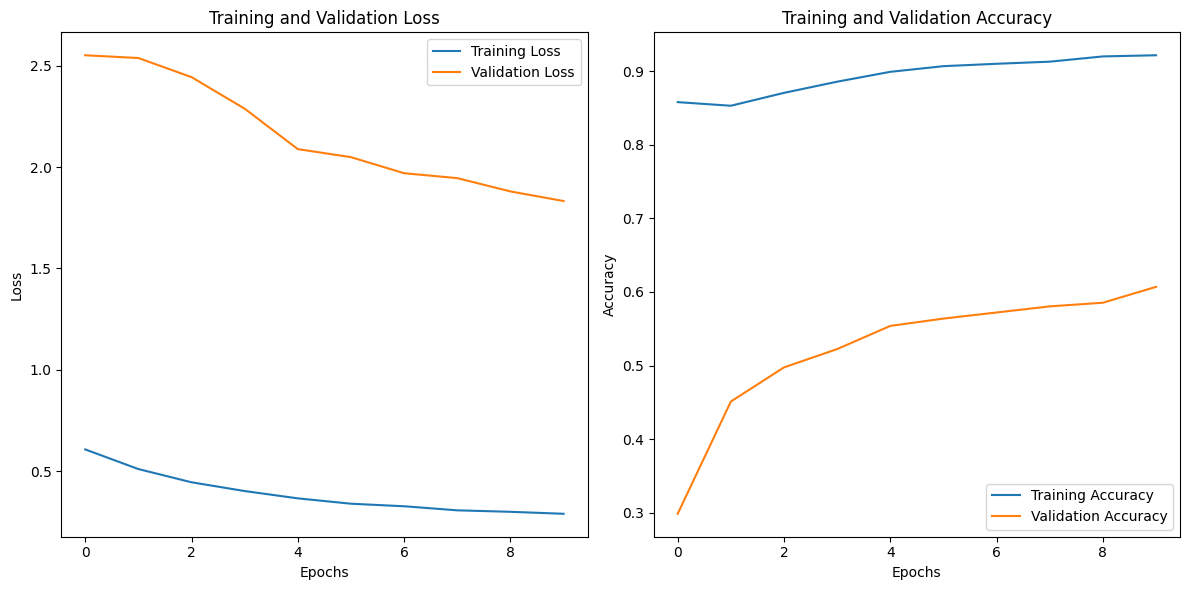

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_a.history['loss'], label='Training Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a.history['accuracy'], label='Training Accuracy')
plt.plot(history_a.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części A (Sieć z warstwami dense):")
results_a = model.evaluate(test_ds)
print(f"Test loss: {results_a[0]}, Test accuracy: {results_a[1]}")

Wyniki części A (Sieć z warstwami dense):
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.3855 - loss: 1.2971
Test loss: 1.0463744401931763, Test accuracy: 0.5956375598907471


In [ ]:
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [ ]:
print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

Top-1 accuracy: 0.5956375838926175
Confusion Matrix:
 [[ 41  39  46   2]
 [ 26 206   2   0]
 [  4   7  97   3]
 [ 29  51  32  11]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Wyciągnięcie cech z modelu bazowego (EfficientNetB0)
def extract_features(model, dataset):
    features, labels = [], []
    for images, lbls in dataset:
        features.append(model.predict(images, verbose=0))
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Wydobycie cech z danych treningowych i testowych
feature_extractor = keras.Model(inputs=model.input, outputs=model.layers[-3].output)
X_train, y_train = extract_features(feature_extractor, train_ds)
X_test, y_test = extract_features(feature_extractor, test_ds)

In [ ]:
# Definicja i trening SVM
kernels = ['linear', 'poly', 'rbf']
svm_results = {}

for kernel in kernels:
    print(f"Trening SVM z jądrem {kernel}...")
    svm_model = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=1, probability=True))
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    svm_results[kernel] = classification_report(y_test, y_pred_svm)
    print(f"Wyniki dla jądra {kernel}:")
    print(svm_results[kernel])
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))

Trening SVM z jądrem linear...
Wyniki dla jądra linear:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       128
           1       0.97      0.92      0.95       234
           2       0.86      0.97      0.92       111
           3       0.90      0.72      0.80       123

    accuracy                           0.88       596
   macro avg       0.87      0.87      0.87       596
weighted avg       0.89      0.88      0.88       596

Confusion Matrix:
 [[113   0   7   8]
 [ 16 216   0   2]
 [  3   0 108   0]
 [ 19   6  10  88]]
Trening SVM z jądrem poly...
Wyniki dla jądra poly:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       128
           1       0.97      1.00      0.99       234
           2       0.93      0.99      0.96       111
           3       1.00      0.74      0.85       123

    accuracy                           0.93       596
   macro avg       0.93      0.92  

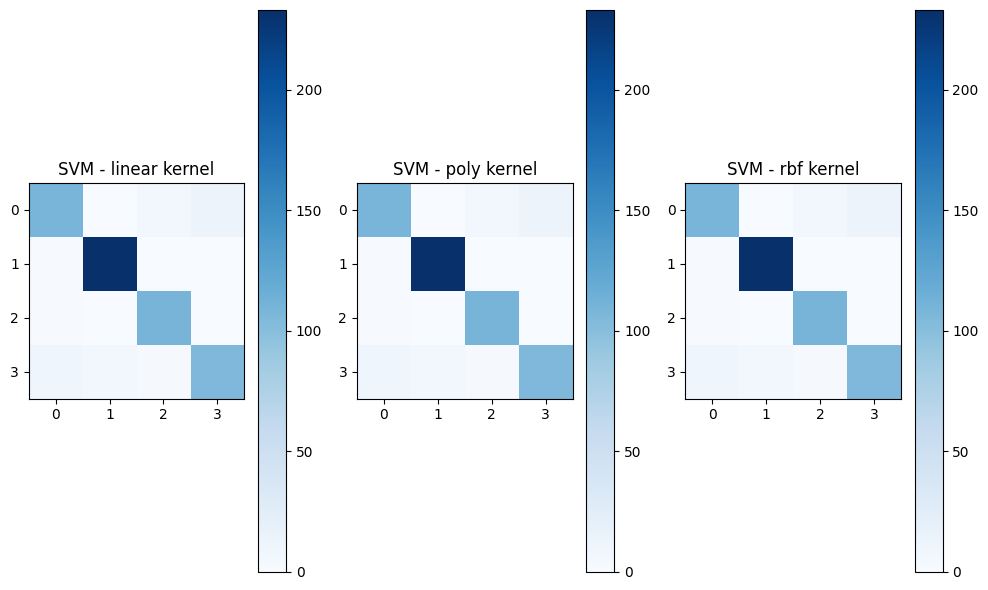

In [ ]:
# Analiza wyników
plt.figure(figsize=(10, 6))
for idx, kernel in enumerate(kernels):
    plt.subplot(1, 3, idx + 1)
    plt.title(f"SVM - {kernel} kernel")
    plt.imshow(confusion_matrix(y_test, svm_model.predict(X_test)), cmap='Blues')
    plt.colorbar()
plt.tight_layout()
plt.show()

# Zadanie 2: Uczenie sieci głębokiej

a. Przeprowadzić uczenie ostatniej warstwy splotowej wraz z częścią
klasyfikującą.

b. Wytrenować całą sieć dla zadanych danych.

c. Uprościć strukturę sieci wytrenowanej w zadaniu 2c (np. poprzez
usunięcie jednej lub więcej końcowych warstw splotowych, usunięcie
warstw regularyzujących itp.) i ponowić uczenie.

d. Zanalizować wyniki 2 abc.


## 2.0 Przygotowanie danych

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint

In [ ]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [ ]:
# Funkcja do wczytywania danych
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
def load_images_and_labels(image_dir, label_dir, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))
    images, labels = [], []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("RGB").resize(img_size)
        images.append(np.asarray(image))

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:  # Pusty plik = ptak
                class_id = 3
            else:
                class_id = int(lines[0].strip().split()[0])  # Samolot (0), dron (1), helikopter (2)
            labels.append(class_id)

    return np.array(images), np.array(labels)

In [ ]:
# Wczytywanie danych
train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir, IMG_SIZE)
valid_images, valid_labels = load_images_and_labels(valid_images_dir, valid_labels_dir, IMG_SIZE)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir, IMG_SIZE)

print(f"Obrazy treningowe: {len(train_images)}, walidacyjne: {len(valid_images)}, testowe: {len(test_images)}")

Obrazy treningowe: 10799, walidacyjne: 603, testowe: 596


Przykładowe dane z datasetu:


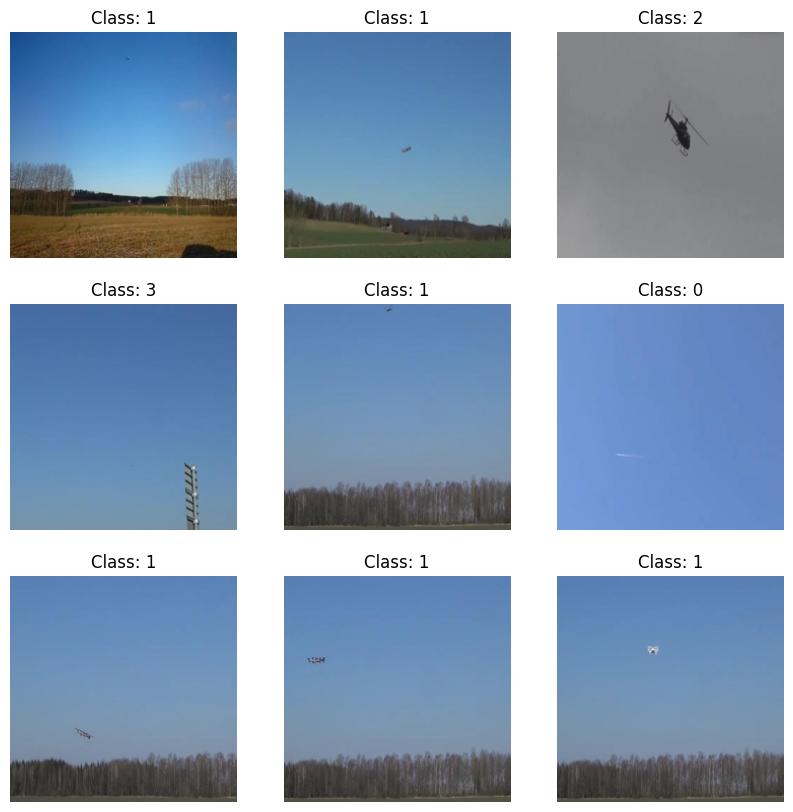

In [ ]:
print("Przykładowe dane z datasetu:")
plt.figure(figsize=(10, 10))
for i in range(9):
    image_no = randint(i+10, len(train_images))
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[image_no])
    plt.title(f"Class: {train_labels[image_no]}")
    plt.axis("off")
plt.show()

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

for images, labels in train_ds.take(1):
    print("Image dtype:", images.dtype)
    print("Min value:", tf.reduce_min(images).numpy())
    print("Max value:", tf.reduce_max(images).numpy())

def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
#valid_ds = valid_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
#test_ds = test_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Image dtype: <dtype: 'uint8'>
Min value: 36
Max value: 192


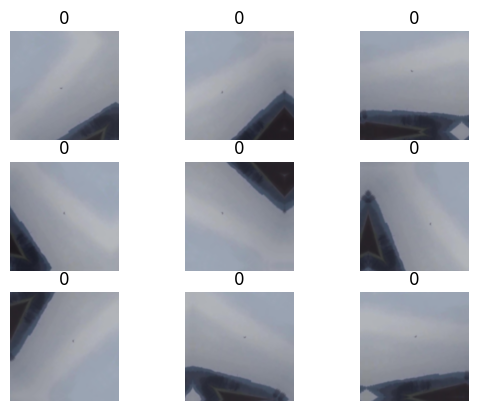

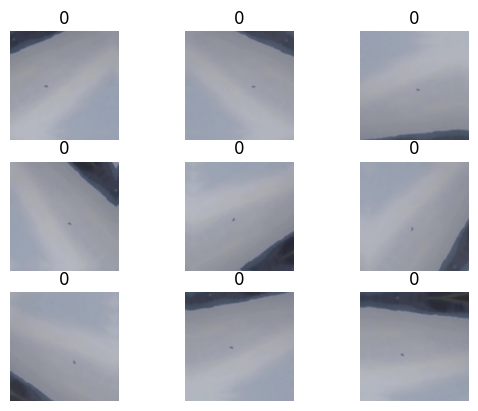

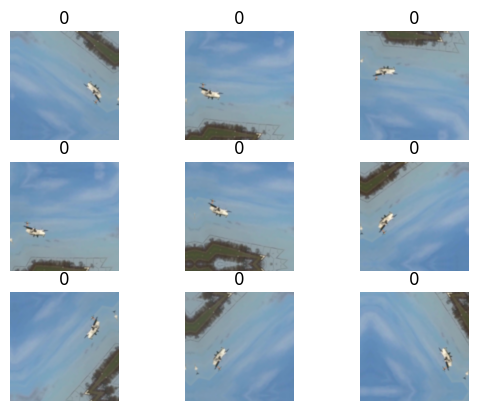

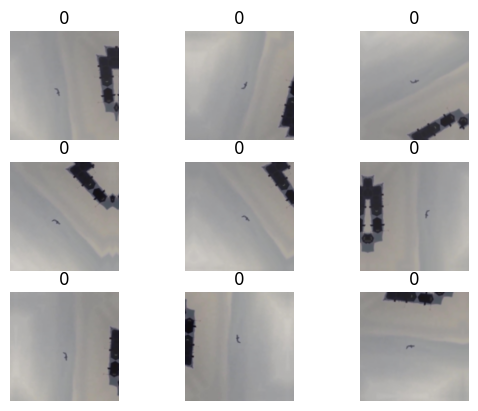

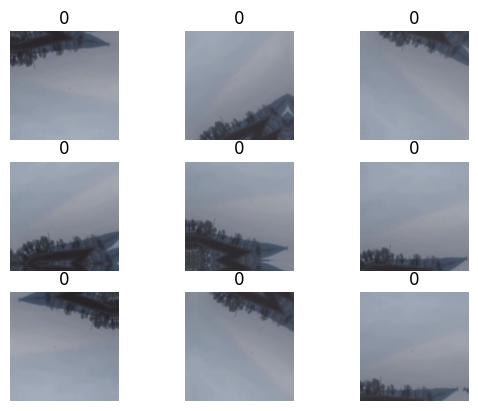

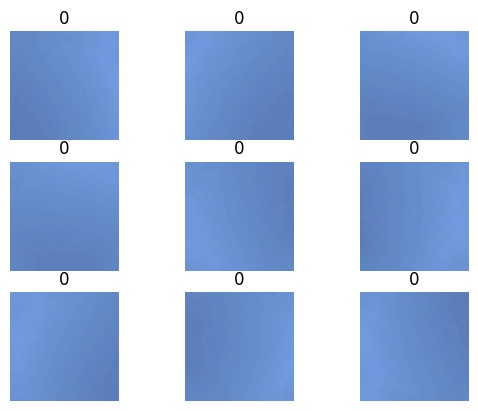

Image dtype: <dtype: 'float32'>
Min value: 28.861649
Max value: 197.57007
Image dtype: <dtype: 'float32'>
Min value: 18.351334
Max value: 255.0
Image dtype: <dtype: 'float32'>
Min value: 2.6250305
Max value: 255.0


In [ ]:
# Prezentacja danych po augmentacji
for image, label in train_ds.take(6):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image)
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title(int(label[0]))
        plt.axis("off")
    plt.show()

for images, labels in train_ds.take(3):
    print("Image dtype:", images.dtype)
    print("Min value:", tf.reduce_min(images).numpy())
    print("Max value:", tf.reduce_max(images).numpy())

## 2a - trenowanie ostataniej warstwy splotowej

In [ ]:
# sprawdzamy jak wyglądają warstwy EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Ostatnia warstwa splotowa to `top_conv` i jest to 3 warstwa od końca, więc odmrażamy 3 ostatnie warstwy.

In [ ]:
# Freeze all layers except the last 3 layers
for layer in base_model.layers[:-3]:
  layer.trainable = False

# The last 3 layers of the base model will be trainable
for layer in base_model.layers[-3:]:
  layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 417,284 (1.59 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Niski learning rate - z 1e-3 i 1e-4 uczenie szło gorzej
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

print("Rozpoczęcie treningu modelu (część A).")
EPOCHS = 20
history_a = model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

Rozpoczęcie treningu modelu (część A).
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 225s 565ms/step - accuracy: 0.2492 - loss: 1.4892 - val_accuracy: 0.4776 - val_loss: 1.2004
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 155s 460ms/step - accuracy: 0.3083 - loss: 1.4453 - val_accuracy: 0.6053 - val_loss: 1.0794
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 158s 467ms/step - accuracy: 0.3441 - loss: 1.3968 - val_accuracy: 0.6202 - val_loss: 1.0143
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 160s 474ms/step - accuracy: 0.3648 - loss: 1.3526 - val_accuracy: 0.6219 - val_loss: 0.9768
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 188s 557ms/step - accuracy: 0.3995 - loss: 1.3063 - val_accuracy: 0.6219 - val_loss: 0.9497
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 169s 501ms/step - accuracy: 0.4406 - loss: 1.2584 - val_accuracy: 0.6235 - val_loss: 0.9269
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 156s 462ms/step - accuracy: 0.4715 - loss: 1.2021 - val_accuracy: 0.6186 - val_loss: 0.9068
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_a.history['loss'], label='Training Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a.history['accuracy'], label='Training Accuracy')
plt.plot(history_a.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części A (uczenie ostatniej warstwy splotowej):")
results_a = model.evaluate(test_ds)
print(f"Test loss: {results_a[0]}, Test accuracy: {results_a[1]}")

In [ ]:
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
import pandas as pd

model.save("umir_model_a_small_lr_no_input_t1.keras")

# Save history to CSV
history_bw2_t2_df = pd.DataFrame(history_a.history)
history_bw2_t2_df.to_csv('umir_model_a_small_lr_no_input_t1_history.csv', index=False)

Trenujemy dalej...

In [ ]:
print("Kontynuacja treningu modelu (część A).")
EPOCHS = 20
history_a_2 = model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_a_2.history['loss'], label='Training Loss')
plt.plot(history_a_2.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_a_2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części A (uczenie ostatniej warstwy splotowej):")
results_a2 = model.evaluate(test_ds)
print(f"Test loss: {results_a2[0]}, Test accuracy: {results_a2[1]}")

In [ ]:
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
import pandas as pd

model.save("umir_model_a_small_lr_no_input_t2.keras")

# Save history to CSV
history_x_df = pd.DataFrame(history_a_2.history)
history_x_df.to_csv('umir_model_a_small_lr_no_input_t2_history.csv', index=False)

I jeszcze raz...

In [ ]:
model = keras.models.load_model('umir_model_a_small_lr_no_input_t2.keras')

In [ ]:
print("Kontynuacja treningu modelu (część A) - t3.")

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

EPOCHS = 25
history_a_3 = model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_a_3.history['loss'], label='Training Loss')
plt.plot(history_a_3.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_a_3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części A (uczenie ostatniej warstwy splotowej):")
results_a3 = model.evaluate(test_ds)
print(f"Test loss: {results_a3[0]}, Test accuracy: {results_a3[1]}")

In [ ]:
y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
import pandas as pd

model.save("umir_model_a_small_lr_no_input_t3.keras")

# Save history to CSV
history_x_df = pd.DataFrame(history_a_3.history)
history_x_df.to_csv('umir_model_a_small_lr_no_input_t3_history.csv', index=False)

## 2b - cała sieć - próba 1 - 47,48%


In [ ]:
base_model_b = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_b.trainable = True

inputs_b = keras.Input(shape=(224, 224, 3))

xb = base_model_b(inputs_b, training=True)
xb = keras.layers.GlobalAveragePooling2D()(xb)
xb = keras.layers.Dropout(0.2)(xb)
outputs_b = keras.layers.Dense(NUM_CLASSES, activation='softmax')(xb)
model_b = keras.Model(inputs_b, outputs_b)

model_b.summary()

In [ ]:
model_b.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Rozpoczęcie treningu modelu (część 2B).")
EPOCHS = 13
history_2b = model_b.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

In [ ]:
results_b = model_b.evaluate(test_ds)
print(f"Test loss: {results_b[0]}, Test accuracy: {results_b[1]}")

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

EPOCHS = 15
history_2b_2 = model_b.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[early_stopping])

In [ ]:
import pandas as pd

history_2b_df = pd.DataFrame(history_2b.history)
history_2b_2_df = pd.DataFrame(history_2b_2.history)
combined_history = pd.concat([history_2b_df, history_2b_2_df], ignore_index=True)

combined_history

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2B:")
results_b = model_b.evaluate(test_ds)
print(f"Test loss: {results_b[0]}, Test accuracy: {results_b[1]}")

In [ ]:
y_pred = model_b.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))


## 2b - cała sieć - próba 2 - 63,25%


In [ ]:
base_model_bw2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_bw2.trainable = True

model_bw2 = models.Sequential([
    base_model_bw2,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model_bw2.summary()

In [ ]:
model_bw2.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Rozpoczęcie treningu modelu (część 2B z wagami v2).")
EPOCHS = 13
history_bw2 = model_bw2.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_bw2.history['loss'], label='Training Loss')
plt.plot(history_bw2.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bw2.history['accuracy'], label='Training Accuracy')
plt.plot(history_bw2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2:")
results_bw2 = model_bw2.evaluate(test_ds)
print(f"Test loss: {results_bw2[0]}, Test accuracy: {results_bw2[1]}")

y_pred = model_bw2.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
model_bw2.save("umir_model_bw2_t1.keras")

In [ ]:
import pandas as pd

# Save history to CSV
history_bw2_df = pd.DataFrame(history_bw2.history)
history_bw2_df.to_csv('umir_model_bw2_t1_history.csv', index=False)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

In [ ]:
model_bw2_t2 = keras.models.load_model('umir_model_bw2_t1.keras')
print("Kontynuacja treningu modelu (umir_model_bw2_t1).")
EPOCHS = 20
history_bw2_t2 = model_bw2_t2.fit(train_ds,
                                  validation_data=valid_ds,
                                  epochs=EPOCHS,
                                  callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_bw2_t2.history['loss'], label='Training Loss')
plt.plot(history_bw2_t2.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bw2_t2.history['accuracy'], label='Training Accuracy')
plt.plot(history_bw2_t2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2t2:")
results_bw2t2 = model_bw2_t2.evaluate(test_ds)
print(f"Test loss: {results_bw2t2[0]}, Test accuracy: {results_bw2t2[1]}")

y_pred = model_bw2_t2.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
import pandas as pd

model_bw2_t2.save("umir_model_bw2_t2.keras")

# Save history to CSV
history_bw2_t2_df = pd.DataFrame(history_bw2_t2.history)
history_bw2_t2_df.to_csv('umir_model_bw2_t2_history.csv', index=False)

In [ ]:
print("Kontynuacja treningu modelu (umir_model_bw2_t2).")
EPOCHS = 8
history_bw2_t3 = model_bw2_t2.fit(train_ds,
                                  validation_data=valid_ds,
                                  epochs=EPOCHS)

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_bw2_t3.history['loss'], label='Training Loss')
plt.plot(history_bw2_t3.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bw2_t3.history['accuracy'], label='Training Accuracy')
plt.plot(history_bw2_t3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2t2:")
results_bw2t3 = model_bw2_t2.evaluate(test_ds)
print(f"Test loss: {results_bw2t3[0]}, Test accuracy: {results_bw2t3[1]}")

y_pred = model_bw2_t2.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
model_bw2_t2.save("umir_model_bw2_t3.keras")

# Save history to CSV
history_bw2_t2_df = pd.DataFrame(history_bw2_t3.history)
history_bw2_t2_df.to_csv('umir_model_bw2_t3_history.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_wrong_predictions(model, test_ds, class_names, max_images_per_class=5):
    """
    Wyświetla obrazy z testowego zbioru danych, które zostały błędnie zaklasyfikowane,
    pogrupowane według prawdziwej klasy (true class).

    Args:
        model: Przeszkolony model.
        test_ds: Zbiór danych testowych w formacie TensorFlow Dataset.
        class_names: Lista nazw klas.
        max_images_per_class: Maksymalna liczba błędnych przykładów do wyświetlenia dla każdej klasy.
    """
    # Słownik do przechowywania błędnych klasyfikacji
    wrong_predictions = {class_idx: [] for class_idx in range(len(class_names))}

    # Debugging: Liczniki przykładów dla każdej klasy
    true_class_counts = {class_idx: 0 for class_idx in range(len(class_names))}
    wrong_class_counts = {class_idx: 0 for class_idx in range(len(class_names))}

    # Iteracja przez zbiór danych testowych
    for images, labels in test_ds:
        # Przewidywanie klas
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)

        # Sprawdzanie błędnych klasyfikacji
        for i in range(len(labels)):
            true_label = labels[i].numpy() if hasattr(labels[i], 'numpy') else labels[i]
            predicted_label = predicted_classes[i]

            # Aktualizacja liczników dla prawdziwej klasy
            true_class_counts[true_label] += 1

            # Zbieranie błędnych przykładów
            if predicted_label != true_label:
                wrong_class_counts[true_label] += 1
                if len(wrong_predictions[true_label]) < max_images_per_class:
                    wrong_predictions[true_label].append((images[i], predicted_label))

    # Debugging: Wyświetlenie statystyk
    print("\nStatystyki dla klas:")
    for class_idx in range(len(class_names)):
        print(f"Klasa {class_idx} ({class_names[class_idx]}):")
        print(f" - Przykłady w zbiorze testowym: {true_class_counts[class_idx]}")
        print(f" - Błędnie zaklasyfikowane: {wrong_class_counts[class_idx]}")

    # Wyświetlanie wyników
    for class_idx, errors in wrong_predictions.items():
        if errors:
            print(f"\nBłędne klasyfikacje dla klasy: {class_names[class_idx]}")
            plt.figure(figsize=(15, 5))
            for i, (image, predicted_label) in enumerate(errors):
                plt.subplot(1, len(errors), i + 1)
                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f"True: {class_names[class_idx]}\nPred: {class_names[predicted_label]}")
                plt.axis("off")
            plt.tight_layout()
            plt.show()

class_names = ["0 samolot", "dron 1", "helikopter 2", "ptak 3"]
display_wrong_predictions(model_bw2_t2, test_ds, class_names, max_images_per_class=5)


## 2b - cała sieć, ale bez wag początkowych - próba 1 - 18,62%


In [ ]:
for images, labels in train_ds.take(1):
    input_shape = images[0].shape
    break

base_model_b = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)
base_model_b.trainable = True

inputs_b = keras.Input(shape=input_shape)

xb = base_model_b(inputs_b, training=True)
xb = keras.layers.GlobalAveragePooling2D()(xb)
xb = keras.layers.Dropout(0.2)(xb)
outputs_b = keras.layers.Dense(NUM_CLASSES, activation='softmax')(xb)
model_b = keras.Model(inputs_b, outputs_b)

model_b.summary()

In [ ]:
model_b.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Rozpoczęcie treningu modelu (część 2B bez wag początkowych).")
EPOCHS = 13
history_2b2 = model_b.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_2b2.history['loss'], label='Training Loss')
plt.plot(history_2b2.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2b2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2b2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2B2:")
results_b = model_b.evaluate(test_ds)
print(f"Test loss: {results_b[0]}, Test accuracy: {results_b[1]}")

In [ ]:
y_pred = model_b.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
model_b.save('umir_2b_v2_t1.keras')

In [ ]:
model_b = keras.models.load_model('umir_2b_v2_t1.keras')

In [ ]:
print("Kontynuacja treningu modelu (część 2B bez wag początkowych).")
EPOCHS = 20
history_2b3 = model_b.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_2b3.history['loss'], label='Training Loss')
plt.plot(history_2b3.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2b3.history['accuracy'], label='Training Accuracy')
plt.plot(history_2b3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2B3:")
results_b = model_b.evaluate(test_ds)
print(f"Test loss: {results_b[0]}, Test accuracy: {results_b[1]}")

In [ ]:
y_pred = model_b.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
model_b.save('umir_2b_v2_t2.keras')

In [ ]:
model_test222 = keras.models.load_model('umir_2b_v2_t2.keras')

In [ ]:
# display test photos with predicted classes

import matplotlib.pyplot as plt
import numpy as np

y_pred = model_test222.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(y_pred, axis=1)

# Iterate through the test dataset and display images with predictions
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
for i, (images, labels) in enumerate(test_ds.take(5)):  # Display 5 batches
    for j in range(min(images.shape[0], 8)):  # Display up to 8 images per batch
      plt.subplot(5, 8, i * 8 + j + 1)
      plt.imshow(images[j].numpy().astype("uint8"))
      plt.title(f"True: {int(labels[j])}, Pred: {predicted_classes[i * BATCH_SIZE + j]}")
      plt.axis("off")
plt.tight_layout()
plt.show()

## 2b - cała sieć, ale bez wag początkowych - próba 2 - 38%

In [ ]:
base_model_none_w = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model_none_w.trainable = True

model_none_w = models.Sequential([
    base_model_none_w,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model_none_w.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

model_none_w.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Rozpoczęcie treningu modelu model_none_w")
EPOCHS = 20
history_none_w = model_none_w.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_none_w.history['loss'], label='Training Loss')
plt.plot(history_none_w.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_none_w.history['accuracy'], label='Training Accuracy')
plt.plot(history_none_w.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części B bez wag poprawa:")
results = model_none_w.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = model_none_w.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))



```
Top-1 accuracy: 0.3825503355704698
Confusion Matrix:
 [[  0 115  13   0]
 [  0 213  21   0]
 [  0  96  15   0]
 [  0 114   9   0]]
```



## 2c - uprościć 2b - próba 1 - 52%

In [ ]:
trained_model = keras.models.load_model('umir_model_bw2_t2.keras')

print("Wyniki modelu z części B:")
results = trained_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = trained_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
trained_model.summary()

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = trained_model.get_layer("efficientnetb0")

# Usuń wybrane warstwy (np. ostatnie bloki MBConv)
# Zatrzymujemy się na warstwie 'block5b_add'
output_layer = base_model.get_layer("block5b_add").output
modified_base_model = Model(inputs=base_model.input, outputs=output_layer)

# Dodaj nową uproszczoną głowicę
x = GlobalAveragePooling2D()(modified_base_model.output)
x = Dense(512, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

# Połącz w nowy model
new_model = Model(inputs=modified_base_model.input, outputs=outputs)

# Zachowaj wagi dla wspólnych warstw
for layer in modified_base_model.layers:
    layer.trainable = True

new_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

new_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

print("Rozpoczęcie treningu modelu new_model")
EPOCHS = 20
history_new_model = new_model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_new_model.history['loss'], label='Training Loss')
plt.plot(history_new_model.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_new_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2t2:")
results = new_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = new_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))



```
Top-1 accuracy: 0.5201342281879194
Confusion Matrix:
 [[  6  25  60  37]
 [  0 175  52   7]
 [  2   5  99   5]
 [  6   7  80  30]]
```



In [ ]:
new_model.save("umir_model_2c_t1.keras")

import pandas as pd

# Save history to CSV
history_bw2_t2_df = pd.DataFrame(history_new_model.history)
history_bw2_t2_df.to_csv('umir_model_2c_t1_history.csv', index=False)

## 2c - uprościć 2b - próba 2 - 44%


In [ ]:
trained_model = keras.models.load_model('umir_model_bw2_t2.keras')

print("Wyniki modelu z części B:")
results = trained_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = trained_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
trained_model.summary()

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = trained_model.get_layer("efficientnetb0")

# Usuń wybrane warstwy (np. ostatnie bloki MBConv)
# Zatrzymujemy się na warstwie 'block7a_project_bn'
output_layer = base_model.get_layer("block7a_project_bn").output
modified_base_model = Model(inputs=base_model.input, outputs=output_layer)

x = GlobalAveragePooling2D()(modified_base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(4, activation="softmax")(x)

new_model = Model(inputs=modified_base_model.input, outputs=outputs)

# Zachowaj wagi dla wspólnych warstw
for layer in modified_base_model.layers:
    layer.trainable = True

new_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

new_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

print("Rozpoczęcie treningu modelu new_model")
EPOCHS = 40
history_new_model = new_model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_new_model.history['loss'], label='Training Loss')
plt.plot(history_new_model.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_new_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2t2:")
results = new_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = new_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))



```
Top-1 accuracy: 0.4446308724832215
Confusion Matrix:
 [[ 13  93   6  16]
 [  0 234   0   0]
 [  4  65  10  32]
 [  0 111   4   8]]
```



## 2c - uprościć 2b - próba 3 - 23%

In [ ]:
trained_model = keras.models.load_model('umir_model_bw2_t2.keras')

print("Wyniki modelu z części B:")
results = trained_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = trained_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_wrong_predictions(model, test_ds, class_names, max_images_per_class=5):
    """
    Wyświetla obrazy z testowego zbioru danych, które zostały błędnie zaklasyfikowane,
    pogrupowane według prawdziwej klasy (true class).

    Args:
        model: Przeszkolony model.
        test_ds: Zbiór danych testowych w formacie TensorFlow Dataset.
        class_names: Lista nazw klas.
        max_images_per_class: Maksymalna liczba błędnych przykładów do wyświetlenia dla każdej klasy.
    """
    # Słownik do przechowywania błędnych klasyfikacji
    wrong_predictions = {class_idx: [] for class_idx in range(len(class_names))}

    # Debugging: Liczniki przykładów dla każdej klasy
    true_class_counts = {class_idx: 0 for class_idx in range(len(class_names))}
    wrong_class_counts = {class_idx: 0 for class_idx in range(len(class_names))}

    # Iteracja przez zbiór danych testowych
    for images, labels in test_ds:
        # Przewidywanie klas
        predictions = model.predict(images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)

        # Sprawdzanie błędnych klasyfikacji
        for i in range(len(labels)):
            true_label = labels[i].numpy() if hasattr(labels[i], 'numpy') else labels[i]
            predicted_label = predicted_classes[i]

            # Aktualizacja liczników dla prawdziwej klasy
            true_class_counts[true_label] += 1

            # Zbieranie błędnych przykładów
            if predicted_label != true_label:
                wrong_class_counts[true_label] += 1
                if len(wrong_predictions[true_label]) < max_images_per_class:
                    wrong_predictions[true_label].append((images[i], predicted_label))

    # Debugging: Wyświetlenie statystyk
    print("\nStatystyki dla klas:")
    for class_idx in range(len(class_names)):
        print(f"Klasa {class_idx} ({class_names[class_idx]}):")
        print(f" - Przykłady w zbiorze testowym: {true_class_counts[class_idx]}")
        print(f" - Błędnie zaklasyfikowane: {wrong_class_counts[class_idx]}")

    # Wyświetlanie wyników
    for class_idx, errors in wrong_predictions.items():
        if errors:
            print(f"\nBłędne klasyfikacje dla klasy: {class_names[class_idx]}")
            plt.figure(figsize=(50, 5))
            for i, (image, predicted_label) in enumerate(errors):
                plt.subplot(1, len(errors), i + 1)
                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f"True: {class_names[class_idx]}\nPred: {class_names[predicted_label]}")
                plt.axis("off")
            plt.tight_layout()
            plt.show()

# Przykład użycia
class_names = ["0 samolot", "dron 1", "helikopter 2", "ptak 3"]  # Zamień na swoje klasy
display_wrong_predictions(trained_model, test_ds, class_names, max_images_per_class=20)


In [ ]:
trained_model.summary()

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = trained_model.get_layer("efficientnetb0")

# Usuń wybrane warstwy (np. ostatnie bloki MBConv)
# Zatrzymujemy się na warstwie 'block6d_add'
output_layer = base_model.get_layer("block6d_add").output
modified_base_model = Model(inputs=base_model.input, outputs=output_layer)

x = GlobalAveragePooling2D()(modified_base_model.output)
x = Dense(512, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

new_model = Model(inputs=modified_base_model.input, outputs=outputs)

for layer in modified_base_model.layers:
    layer.trainable = True

new_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

new_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

print("Rozpoczęcie treningu modelu new_model")
EPOCHS = 30
history_new_model = new_model.fit(train_ds,
                      validation_data=valid_ds,
                      epochs=EPOCHS,
                      callbacks=[early_stopping])

In [ ]:
# Wizualizacja wyników treningu
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_new_model.history['loss'], label='Training Loss')
plt.plot(history_new_model.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_new_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Wyniki części 2bw2t2:")
results = new_model.evaluate(test_ds)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

y_pred = new_model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

In [ ]:
new_model.save("umir_model_2c_t1.keras")

import pandas as pd

# Save history to CSV
history_bw2_t2_df = pd.DataFrame(history_new_model.history)
history_bw2_t2_df.to_csv('umir_model_2c_t1_history.csv', index=False)

# Zadanie 3



1.   Dokonać wizualnej analizy błędnych klasyfikacji dla wybranej wersji sieci z zadania 1 lub 2 pod kątem znalezienia potencjalnych przyczyn oraz detekcji błędnych oznaczeń w wykorzystywanej bazie danych.
2.    Dokonać wizualizacji obszarów uwagi sieci wytrenowanych w zadaniu 1 oraz 2 z wykorzystaniem metod Class Activation Map (CAM).
3.   Dokonać wizualizacji aktywacji wewnętrznych warstw sieci z wykorzystaniem techniki DeepDream.
4.  Przygotować własny zbiór zdjęć dla wybranych kategorii (kilkadziesiąt zdjęć)oraz zanalizować wyniki klasyfikacji dla wszystkich wytrenowanych sieci z punktów 1 oraz 2. Do przygotowania zbioru można wykorzystać modele generatywne AI (np. Midjourney)


In [ ]:
# Setup

import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler

# Download latest version
path = kagglehub.dataset_download("cybersimar08/drone-detection")

print("Path to dataset files:", path)
train_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "images")
train_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "labels")
valid_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "images")
valid_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "labels")
test_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "images")
test_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "labels")

IMG_SIZE = (128, 128)
NUM_CLASSES = 4

# Funkcja do wczytywania danych
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
def load_images_and_labels(image_dir, label_dir, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))
    images, labels = [], []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("RGB").resize(img_size)
        images.append(np.asarray(image))

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:  # Pusty plik = ptak
                class_id = 3
            else:
                class_id = int(lines[0].strip().split()[0])  # Samolot (0), dron (1), helikopter (2)
            labels.append(class_id)

    return np.array(images), np.array(labels)

    # Wczytywanie danych
train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir, IMG_SIZE)
valid_images, valid_labels = load_images_and_labels(valid_images_dir, valid_labels_dir, IMG_SIZE)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir, IMG_SIZE)

print(f"Obrazy treningowe: {len(train_images)}, walidacyjne: {len(valid_images)}, testowe: {len(test_images)}")

img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)





Path to dataset files: /root/.cache/kagglehub/datasets/cybersimar08/drone-detection/versions/3
Obrazy treningowe: 10799, walidacyjne: 603, testowe: 596


In [ ]:
for images, labels in train_ds.take(1):
    input_shape = images[0].shape
    break

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Zamrożenie wag


inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Rozpoczęcie treningu modelu (część A).")
EPOCHS = 5
history_a = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)

results_a = model.evaluate(test_ds)
print(f"Test loss: {results_a[0]}, Test accuracy: {results_a[1]}")

y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

##Podpunkt #1 - dla wersji sieci z klasyfikatorem SVM - jądro poly

Trening SVM z jądrem poly...
Raport klasyfikacji dla SVM (kernel='poly'):
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       128
           1       0.98      1.00      0.99       234
           2       0.91      0.95      0.93       111
           3       0.99      0.71      0.82       123

    accuracy                           0.92       596
   macro avg       0.91      0.90      0.90       596
weighted avg       0.93      0.92      0.91       596

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 764ms/step - accuracy: 0.2367 - loss: 3.9992
Test loss: 2.298403024673462, Test accuracy: 0.536912739276886
Top-1 accuracy: 0.9161073825503355
Confusion Matrix:
 [[120   0   7   1]
 [  0 234   0   0]
 [  6   0 105   0]
 [ 27   5   4  87]]


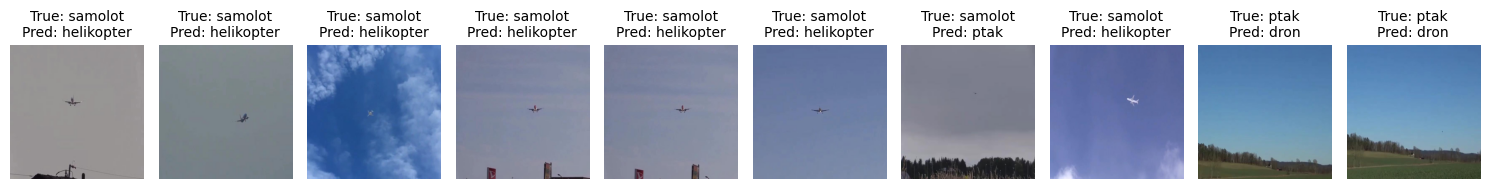

In [ ]:
def load_original_sized_images(images_dir):
  image_files = sorted(os.listdir(images_dir))
  original_sized_images = []
  for image_path in image_files:
    img_path = os.path.join(images_dir, image_path)
    image = Image.open(img_path).convert("RGB")
    original_sized_images.append(np.asarray(image))
  return np.array(original_sized_images)

def extract_features_with_images(model, dataset):
    features, labels, original_images = [], [], []
    for images, lbls in dataset:
        features.append(model.predict(images, verbose=0))
        labels.append(lbls.numpy())
        original_images.append(images.numpy())  # Zapisz oryginalne obrazy
    return (
        np.concatenate(features),
        np.concatenate(labels),
        np.concatenate(original_images))

feature_extractor = keras.Model(inputs=model.input, outputs=model.layers[-3].output)
X_train, y_train, images_train = extract_features_with_images(feature_extractor, train_ds)
X_valid, y_valid, images_valid = extract_features_with_images(feature_extractor, valid_ds)
X_test, y_test, images_test = extract_features_with_images(feature_extractor, test_ds)
images_test_original_sized = load_original_sized_images(test_images_dir)

from sklearn.metrics import accuracy_score
print(f"Trening SVM z jądrem poly...")
svm_model = make_pipeline(StandardScaler(), SVC(kernel='poly', C=1, probability=True))
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla SVM (kernel='poly'):")
print(classification_report(y_test, y_pred_svm))

print("Top-1 accuracy:", accuracy_score(y_test, y_pred_svm))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))

# Błędne klasyfikacje:

# Funkcja do wizualizacji błędnych klasyfikacji
def visualize_misclassifications(images, labels, predictions, class_names, num_to_show=10):
    """
    Wizualizuje błędnie sklasyfikowane obrazy.

    Args:
    images (numpy array): Oryginalne obrazy w formacie (M, N, C) lub (M, N).
    labels (numpy array): Rzeczywiste etykiety obrazów.
    predictions (numpy array): Przewidywania modelu.
    class_names (list): Lista nazw klas odpowiadających etykietom.
    num_to_show (int): Liczba obrazów do wizualizacji.
    """
    misclassified_indices = [i for i in range(len(labels)) if labels[i] != predictions[i]]
    misclassified_indices = misclassified_indices[:num_to_show]

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices):
        plt.subplot(1, len(misclassified_indices), i + 1)
        img = images[idx]
        if img.ndim == 3 and img.shape[-1] == 1:  # Jeśli obraz jest w skali szarości
            img = img.squeeze(-1)
        plt.imshow(img.astype('uint8'), cmap='gray' if img.ndim == 2 else None)
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


class_names = ["samolot", "dron", "helikopter", "ptak"]
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
# Wizualizacja błędnych klasyfikacji

visualize_misclassifications(images_test_original_sized, y_test, y_pred_svm, class_names, num_to_show=10)

In [ ]:
from google.colab import files
import os
from PIL import Image

def save_misclassified_images(images, labels, predictions, class_names, output_dir='misclassified_images', num_to_save=0):
    """
    Zapisuje błędnie sklasyfikowane obrazy do osobnych plików PNG.

    Args:
        images (numpy array): Oryginalne obrazy w formacie (H, W, 3) lub (H, W),
                              ewentualnie z pierwszym wymiarem określającym liczbę obrazów.
        labels (numpy array): Rzeczywiste etykiety obrazów.
        predictions (numpy array): Przewidywania modelu (np. numery klas).
        class_names (list): Lista nazw klas odpowiadających etykietom.
        output_dir (str): Ścieżka do katalogu, w którym zapiszemy obrazy.
        num_to_save (int): Liczba obrazów do zapisania.
    """
    print(f"wczytano {len(images)} obrazow")
    print(f"wczytano {len(labels)} prawdziwych etykiet")
    print(f"wczytano {len(images)} przewidywanych etykiet")
    # Szukamy indeksów wszystkich źle sklasyfikowanych przypadków
    misclassified_indices = [i for i in range(len(labels)) if labels[i] != predictions[i]]
    # Zostawiamy tylko pierwsze num_to_save
    if not num_to_save:
      num_to_save = len(images)
    misclassified_indices = misclassified_indices[:num_to_save]

    # Upewniamy się, że katalog docelowy istnieje
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Zapisujemy błędnie sklasyfikowane obrazy do plików
    for i, idx in enumerate(misclassified_indices):
        img = images[idx]

        # Jeśli obraz jest w formie (H, W, 1) – skala szarości
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)

        # Konwersja do uint8, jeśli nie jest w tym typie
        img = img.astype('uint8')

        # Tworzymy nazwę pliku: np. "0_true_samolot_pred_dron.png"
        file_name = f"{i}_true_{class_names[labels[idx]]}_pred_{class_names[predictions[idx]]}.png"
        file_path = os.path.join(output_dir, file_name)

        # Zapis z użyciem PIL
        pil_image = Image.fromarray(img)
        pil_image.save(file_path, format='PNG')

    print(f"Błędnie sklasyfikowane obrazy zostały zapisane w katalogu: {output_dir}")

save_misclassified_images(
images_test_original_sized,  # lub inny zbiór
y_test,
y_pred_svm,
class_names,
output_dir='misclassified_images',
num_to_save=0)
    # Spakowanie
!zip -r misclassified_images.zip misclassified_images

# Pobranie
files.download("misclassified_images.zip")




wczytano 596 obrazow
wczytano 596 prawdziwych etykiet
wczytano 596 przewidywanych etykiet
Błędnie sklasyfikowane obrazy zostały zapisane w katalogu: misclassified_images
updating: misclassified_images/ (stored 0%)
updating: misclassified_images/22_true_ptak_pred_samolot.png (deflated 3%)
updating: misclassified_images/0_true_samolot_pred_ptak.png (deflated 0%)
updating: misclassified_images/23_true_ptak_pred_samolot.png (deflated 2%)
updating: misclassified_images/4_true_samolot_pred_helikopter.png (deflated 0%)
updating: misclassified_images/11_true_ptak_pred_dron.png (deflated 0%)
updating: misclassified_images/17_true_ptak_pred_samolot.png (deflated 6%)
updating: misclassified_images/29_true_ptak_pred_samolot.png (deflated 0%)
updating: misclassified_images/13_true_ptak_pred_dron.png (deflated 1%)
updating: misclassified_images/2_true_samolot_pred_ptak.png (deflated 0%)
updating: misclassified_images/1_true_samolot_pred_ptak.png (deflated 0%)
updating: misclassified_images/18_true_p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Podpunkt #2

Dokonać wizualizacji obszarów uwagi sieci wytrenowanych w zadaniu 1 oraz 2 z wykorzystaniem metod Class Activation Map (CAM).

### wersja sieci z zad1

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Zbuduj submodel (Model) zwracający wyjście ostatniej warstwy conv oraz wyjście modelu
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[last_conv_layer.output, model.output]
    )

    # 2. Otwórz 'GradientTape' i oblicz grad.
    with tf.GradientTape() as tape:
        (conv_outputs, predictions) = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # 3. Oblicz gradienty
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Przemnóż cechy przez średnie gradienty
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 5. ReLU oraz normalizacja do [0,1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-9)
    return heatmap.numpy()



def overlay_heatmap(
    heatmap,
    original_image,
    alpha=0.4,
    colormap=cm.jet
):
    """
    Nakłada mapę ciepła (heatmap) na obraz.

    Args:
        heatmap (np.array): 2D mapa ciepła o wartościach w [0,1].
        original_image (np.array): Oryginalny obraz w postaci (H, W, 3).
        alpha (float): Przezroczystość nakładanej mapy ciepła.
        colormap: Mapa kolorów z matplotlib.cm (np. cm.jet, cm.viridis).

    Returns:
        superimposed_img (np.array): Obraz z nałożoną mapą ciepła w formacie uint8.
    """
    # Zmieniamy 2D heatmap na RGB w oparciu o wybrany colormap
    heatmap_colored = colormap(heatmap)[:, :, :3]  # odcinamy kanał alfa, jeśli jest

    # Konwersja do uint8
    heatmap_colored = (heatmap_colored * 255).astype("uint8")

    # Upewniamy się, że oryginalny obraz jest w float32 do nakładania
    if original_image.dtype != np.float32:
        original_image_float = original_image.astype(np.float32)
    else:
        original_image_float = original_image

    # Jeśli wartości oryginalnego obrazu są w 0-255, normalizujemy do [0,1]
    if original_image_float.max() > 1.0:
        original_image_float /= 255.0

    # Tworzymy nakładkę
    superimposed_img = (1 - alpha) * original_image_float + alpha * heatmap_colored / 255.0

    # Skalujemy z powrotem do zakresu 0-255
    superimposed_img = np.clip(superimposed_img * 255.0, 0, 255).astype("uint8")

    return superimposed_img

def overlay_heatmap_on_original(original_img, heatmap, alpha=0.4, colormap=cm.jet):
    """
    Skaluje heatmape i nakłada na obraz oryginalny.
    """
    # Najpierw przeskalowujemy heatmap do rozmiarów oryginalnego obrazu
    h_orig, w_orig = original_img.shape[:2]
    heatmap_resized = np.array(Image.fromarray(heatmap).resize((w_orig, h_orig), Image.BICUBIC))

    # Następnie korzystamy z overlay_heatmap
    return overlay_heatmap(heatmap_resized, original_img, alpha=alpha, colormap=colormap)


In [ ]:
def load_original_sized_images(images_dir):
  image_files = sorted(os.listdir(images_dir))
  original_sized_images = []
  for image_path in image_files:
    img_path = os.path.join(images_dir, image_path)
    image = Image.open(img_path).convert("RGB")
    original_sized_images.append(np.asarray(image))
  return np.array(original_sized_images)


In [ ]:
test_images_original_sized = load_original_sized_images(test_images_dir)

model.summary()
base_model = model.get_layer("efficientnetb0")  # pobranie sub-modelu
base_model.summary()

In [ ]:
class_names = ["samolot", "dron", "helikopter", "ptak"]
def visualize_heatmap(base_model, model, image, oryginal_image, true_label):
  sample_image_expanded = np.expand_dims(image, axis=0)
  preds = model.predict(sample_image_expanded)
  predicted_class_index = np.argmax(preds)
  predicted_class_name = class_names[predicted_class_index]
  true_class_name = class_names[true_label]
  print(f"Prawdziwa etykieta: {true_class_name}")
  print(f"Predykcja modelu: {predicted_class_name}")
  print("Model preds:", preds)

  # Obliczamy heatmapę
  heatmap = make_gradcam_heatmap(
      sample_image_expanded,
      base_model,
      last_conv_layer_name="top_conv",
      pred_index=predicted_class_index
  )


  # Nakładamy mapę ciepła na oryginalny obraz w rozmiarze 128x128
  superimposed_img = overlay_heatmap_on_original(image,heatmap)
  superimposed_full = overlay_heatmap_on_original(oryginal_image, heatmap)

  # Wizualizacja
  plt.figure(figsize=(12, 8))  # Ustaw większy rozmiar dla lepszego rozmieszczenia

  # Oryginalny obraz
  plt.subplot(2, 2, 1)
  plt.title("Oryginalny obraz (128x128)")
  plt.imshow(image.astype('uint8'))
  plt.axis('off')

  # Mapa ciepła (Grad-CAM)
  plt.subplot(2, 2, 2)
  plt.title("Mapa ciepła (Grad-CAM)")
  plt.imshow(heatmap, cmap='jet')
  plt.axis('off')

  # Nałożenie heatmapy (128x128)
  plt.subplot(2, 2, 3)
  plt.title("Nałożenie heatmapy (128x128)")
  plt.imshow(superimposed_img)
  plt.axis('off')

  # Nałożenie heatmapy w pełnej skali
  plt.subplot(2, 2, 4)
  plt.title("Nałożenie heatmapy (pełna skala)")
  plt.imshow(superimposed_full)
  plt.axis('off')

  # Rozmieszczenie elementów
  plt.tight_layout()
  plt.show()
for i in range(1):
  print(f"Model: {base_model.name}")
  visualize_heatmap(base_model, model, image=test_images[i], oryginal_image=test_images_original_sized[i], true_label=test_labels[i])



NameError: name 'base_model' is not defined

In [ ]:
import os
import zipfile
import shutil  # Dodano do czyszczenia katalogu

class_names = ["samolot", "dron", "helikopter", "ptak"]

# Funkcja czyszcząca katalog
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Usuwa cały katalog i jego zawartość
    os.makedirs(directory)  # Tworzy pusty katalog

# Wyczyść katalog "heatmaps" przed rozpoczęciem generowania
clear_directory("heatmaps")

def visualize_and_save_heatmap(base_model, model, image, oryginal_image, true_label, file_id, save_dir="heatmaps"):
    # Przygotowanie danych wejściowych
    sample_image_expanded = np.expand_dims(image, axis=0)
    preds = model.predict(sample_image_expanded)
    predicted_class_index = np.argmax(preds)
    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_label]

    # Obliczamy heatmapę
    heatmap = make_gradcam_heatmap(
        sample_image_expanded,
        base_model,
        last_conv_layer_name="block5b_project_conv",
        pred_index=predicted_class_index
    )

    # Nakładamy heatmapę na obraz
    superimposed_img = overlay_heatmap_on_original(image, heatmap)
    superimposed_full = overlay_heatmap_on_original(oryginal_image, heatmap)

    # Wizualizacja
    plt.figure(figsize=(12, 8))  # Ustaw większy rozmiar dla lepszego rozmieszczenia

    # Tytuł główny figury
    plt.suptitle(f"Prawdziwa etykieta: {true_class_name}\n"
                 f"Predykcja modelu: {predicted_class_name}\n"
                 f"Model preds: {preds}")

    # Oryginalny obraz
    plt.subplot(2, 2, 1)
    plt.title("Oryginalny obraz (128x128)")
    plt.imshow(image.astype('uint8'))
    plt.axis('off')

    # Mapa ciepła (Grad-CAM)
    plt.subplot(2, 2, 2)
    plt.title("Mapa ciepła (Grad-CAM)")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    # Nałożenie heatmapy (128x128)
    plt.subplot(2, 2, 3)
    plt.title("Nałożenie heatmapy (128x128)")
    plt.imshow(superimposed_img)
    plt.axis('off')

    # Nałożenie heatmapy w pełnej skali
    plt.subplot(2, 2, 4)
    plt.title("Nałożenie heatmapy (pełna skala)")
    plt.imshow(superimposed_full)
    plt.axis('off')

    # Określenie folderu na podstawie poprawności predykcji
    subdir = "good_predictions" if predicted_class_index == true_label else "false_predictions"
    save_path = os.path.join(save_dir, subdir)
    os.makedirs(save_path, exist_ok=True)

    # Zapis figury do pliku
    file_name = f"heatmap_{file_id}_true_{true_class_name}_pred_{predicted_class_name}.png"
    file_path = os.path.join(save_path, file_name)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.close()




In [ ]:
print(f"test_images_original_sized: {len(test_images_original_sized)}")
print(f"test_images: {len(test_images)}")
print(f"test_labels: {len(test_labels)}")

# Tworzenie heatmap dla wszystkich obrazów
for i in range(len(test_images)):
    print(f"processing test_image: {i}/{len(test_images)}")
    visualize_and_save_heatmap(
        base_model, model,
        image=test_images[i],
        oryginal_image=test_images_original_sized[i],
        true_label=test_labels[i],
        file_id=i
    )

# Pakowanie wszystkich plików do archiwum ZIP
zip_file_path = f"zad1_{base_model.name}_heatmaps.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk("heatmaps"):
        for file in files:
            # Dodanie plików z odpowiednią strukturą katalogów
            relative_path = os.path.relpath(os.path.join(root, file), "heatmaps")
            zipf.write(os.path.join(root, file), arcname=relative_path)

# Pobieranie archiwum ZIP w Google Colab
from google.colab import files
files.download(zip_file_path)

### wersja sieci z zad2a

In [ ]:
trained_model = keras.models.load_model('umir_model_a_small_lr_no_input_t1.keras')
test_images_original_sized = load_original_sized_images(test_images_dir)

trained_model.summary()
base_model = trained_model.get_layer("efficientnetb0")  # pobranie sub-modelu
base_model.summary()
print(f"test_images_original_sized: {len(test_images_original_sized)}")
print(f"test_images: {len(test_images)}")
print(f"test_labels: {len(test_labels)}")

# Tworzenie heatmap dla wszystkich obrazów
for i in range(len(test_images)):
    print(f"processing test_image: {i}/{len(test_images)}")
    visualize_and_save_heatmap(
        base_model, trained_model,
        image=test_images[i],
        oryginal_image=test_images_original_sized[i],
        true_label=test_labels[i],
        file_id=i
    )

# Pakowanie wszystkich plików do archiwum ZIP
zip_file_path = f"zad2a_{base_model.name}_heatmaps.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk("heatmaps"):
        for file in files:
            # Dodanie plików z odpowiednią strukturą katalogów
            relative_path = os.path.relpath(os.path.join(root, file), "heatmaps")
            zipf.write(os.path.join(root, file), arcname=relative_path)

# Pobieranie archiwum ZIP w Google Colab
from google.colab import files
files.download(zip_file_path)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,889,265 (18.65 MB)

 Trainable params: 417,284 (1.59 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

 Optimizer params: 834,570 (3.18 MB)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 412,160 (1.57 MB)

 Non-trainable params: 3,637,411 (13.88 MB)

test_images_original_sized: 596
test_images: 596
test_labels: 596
processing test_image: 0/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
processing test_image: 1/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
processing test_image: 2/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 3/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
processing test_image: 4/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 5/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 6/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
processing test_image: 7/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
processing test_image: 8/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 9/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 10/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
processing test_image: 11/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
processing test_image: 12/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
processing test_image: 13/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### wersja sieci z zad2b


In [ ]:
trained_model = keras.models.load_model('umir_2b_v2_t1.keras')
test_images_original_sized = load_original_sized_images(test_images_dir)

trained_model.summary()
base_model = trained_model.get_layer("efficientnetb0")  # pobranie sub-modelu
base_model.summary()
print(f"test_images_original_sized: {len(test_images_original_sized)}")
print(f"test_images: {len(test_images)}")
print(f"test_labels: {len(test_labels)}")

# Tworzenie heatmap dla wszystkich obrazów
for i in range(len(test_images)):
    print(f"processing test_image: {i}/{len(test_images)}")
    visualize_and_save_heatmap(
        base_model, trained_model,
        image=test_images[i],
        oryginal_image=test_images_original_sized[i],
        true_label=test_labels[i],
        file_id=i
    )

# Pakowanie wszystkich plików do archiwum ZIP
zip_file_path = f"zad2b_{base_model.name}_heatmaps.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk("heatmaps"):
        for file in files:
            # Dodanie plików z odpowiednią strukturą katalogów
            relative_path = os.path.relpath(os.path.join(root, file), "heatmaps")
            zipf.write(os.path.join(root, file), arcname=relative_path)

# Pobieranie archiwum ZIP w Google Colab
from google.colab import files
files.download(zip_file_path)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,080,041 (46.08 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,025,346 (30.61 MB)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

test_images_original_sized: 596
test_images: 596
test_labels: 596
processing test_image: 0/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
processing test_image: 1/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
processing test_image: 2/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
processing test_image: 3/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
processing test_image: 4/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 5/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
processing test_image: 6/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
processing test_image: 7/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 8/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
processing test_image: 9/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 10/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
processing test_image: 11/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
processing test_image: 12/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
processing test_image: 13/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



### wersja sieci z zad2c

In [ ]:
trained_model = keras.models.load_model("umir_model_2c_t1.keras")
test_images_original_sized = load_original_sized_images(test_images_dir)

trained_model.summary()
base_model = trained_model
base_model.summary()
print(f"test_images_original_sized: {len(test_images_original_sized)}")
print(f"test_images: {len(test_images)}")
print(f"test_labels: {len(test_labels)}")

# Tworzenie heatmap dla wszystkich obrazów
for i in range(len(test_images)):
    print(f"processing test_image: {i}/{len(test_images)}")
    visualize_and_save_heatmap(
        base_model, trained_model,
        image=test_images[i],
        oryginal_image=test_images_original_sized[i],
        true_label=test_labels[i],
        file_id=i
    )

# Pakowanie wszystkich plików do archiwum ZIP
zip_file_path = f"zad2c_{base_model.name}_heatmaps.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for root, dirs, files in os.walk("heatmaps"):
        for file in files:
            # Dodanie plików z odpowiednią strukturą katalogów
            relative_path = os.path.relpath(os.path.join(root, file), "heatmaps")
            zipf.write(os.path.join(root, file), arcname=relative_path)

# Pobieranie archiwum ZIP w Google Colab
from google.colab import files
files.download(zip_file_path)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 2,122,689 (8.10 MB)

 Trainable params: 703,144 (2.68 MB)

 Non-trainable params: 13,255 (51.78 KB)

 Optimizer params: 1,406,290 (5.36 MB)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 2,122,689 (8.10 MB)

 Trainable params: 703,144 (2.68 MB)

 Non-trainable params: 13,255 (51.78 KB)

 Optimizer params: 1,406,290 (5.36 MB)

test_images_original_sized: 596
test_images: 596
test_labels: 596
processing test_image: 0/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
processing test_image: 1/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
processing test_image: 2/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
processing test_image: 3/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
processing test_image: 4/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
processing test_image: 5/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
processing test_image: 6/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
processing test_image: 7/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
processing test_image: 8/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
processing test_image: 9/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
processing test_image: 10/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
processing test_image: 11/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
processing test_image: 12/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
processing test_image: 13/596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Podpunkt #3

Dokonać wizualizacji aktywacji wewnętrznych warstw sieci z wykorzystaniem techniki DeepDream.

In [ ]:
# =======================================
# 1. Importy i przygotowanie środowiska
# =======================================
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler

# =======================================
# 2. Pobranie przykładowego zbioru danych
# =======================================
path = kagglehub.dataset_download("cybersimar08/drone-detection")

print("Path to dataset files:", path)
train_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "images")
train_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "labels")
valid_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "images")
valid_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "labels")
test_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "images")
test_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "labels")

IMG_SIZE = (128, 128)
NUM_CLASSES = 4

# ============================================
# 3. Funkcja do wczytywania obrazów i etykiet
# ============================================
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
def load_images_and_labels(image_dir, label_dir, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))
    images, labels = [], []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("RGB").resize(img_size)
        images.append(np.asarray(image))

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:  # Pusty plik = ptak
                class_id = 3
            else:
                class_id = int(lines[0].strip().split()[0])  # Samolot (0), dron (1), helikopter (2)
            labels.append(class_id)

    return np.array(images), np.array(labels)

# Wczytanie danych
train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir, IMG_SIZE)
valid_images, valid_labels = load_images_and_labels(valid_images_dir, valid_labels_dir, IMG_SIZE)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir, IMG_SIZE)

print(f"Obrazy treningowe: {len(train_images)}, walidacyjne: {len(valid_images)}, testowe: {len(test_images)}")

# =====================
# 4. Augmentacja danych
# =====================
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# ======================
# 5. Przygotowanie tf.data
# ======================
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label

def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



100%|██████████| 499M/499M [00:18<00:00, 28.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cybersimar08/drone-detection/versions/3


KeyboardInterrupt: 

In [ ]:
# Wyciągamy kształt wejścia z jednej próbki
for images_batch, labels_batch in train_ds.take(1):
    input_shape = images_batch[0].shape
    break

# =======================================
# 6. Definiujemy i trenujemy model (część A)
# =======================================
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
base_efficientnet.trainable = False  # Zamrożenie wag

inputs = keras.Input(shape=input_shape)
x = base_efficientnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Dodaj dropout
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Rozpoczęcie treningu modelu (część A).")
EPOCHS = 5
history_a = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)
model.save('umir_model_3c.keras')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Rozpoczęcie treningu modelu (część A).
Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 108s 225ms/step - accuracy: 0.8808 - loss: 0.5819 - val_accuracy: 0.3035 - val_loss: 2.6392
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 107s 167ms/step - accuracy: 0.7283 - loss: 1.1232 - val_accuracy: 0.5174 - val_loss: 2.3504
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - accuracy: 0.7421 - loss: 0.9761 - val_accuracy: 0.5124 - val_loss: 2.3782
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 164ms/step - accuracy: 0.7610 - loss: 0.8943 - val_accuracy: 0.5373 - val_loss: 2.3489
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.7829 - loss: 0.8513 - val_accuracy: 0.5307 - val_loss: 2.2218


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

Wyświetlanie pierwszych 30 obrazków z ich DeepDream:
Obraz 1 - Oryginalny:


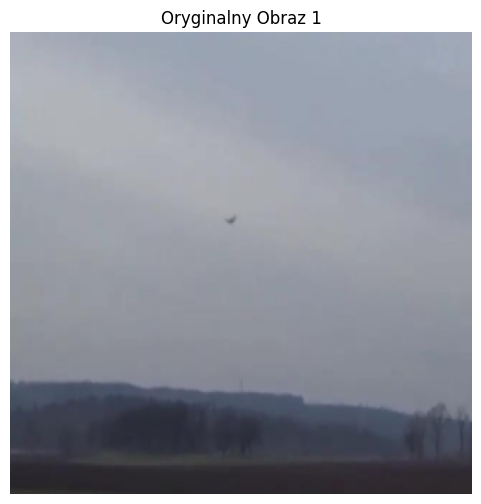

Obraz 1 - DeepDream:


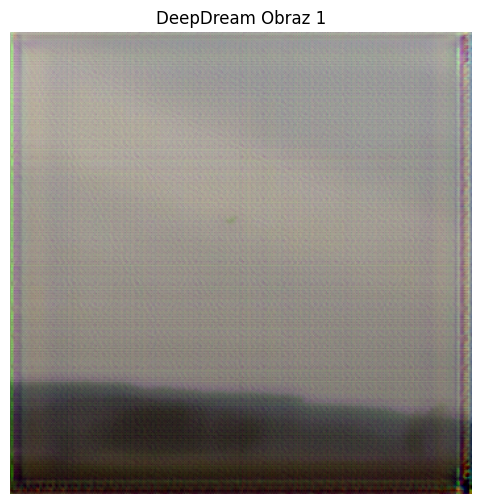

Obraz 2 - Oryginalny:


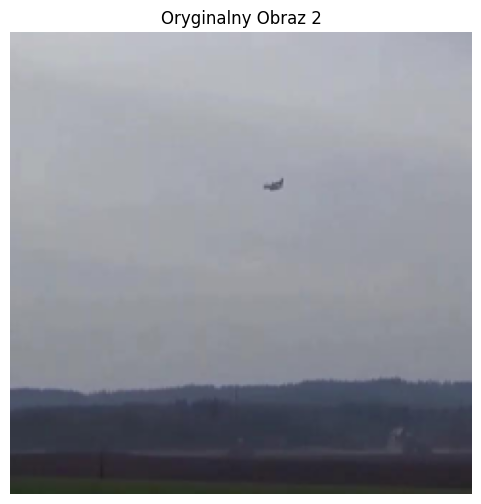

Obraz 2 - DeepDream:


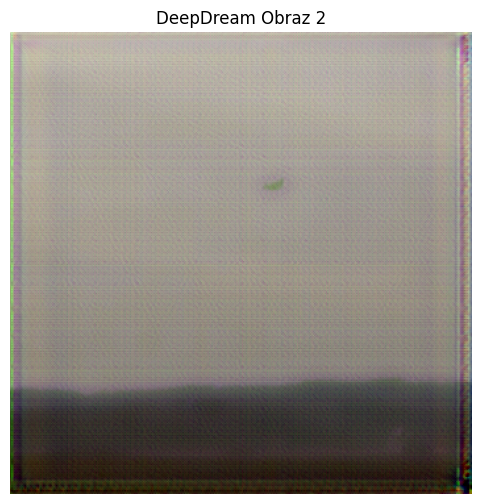

Obraz 3 - Oryginalny:


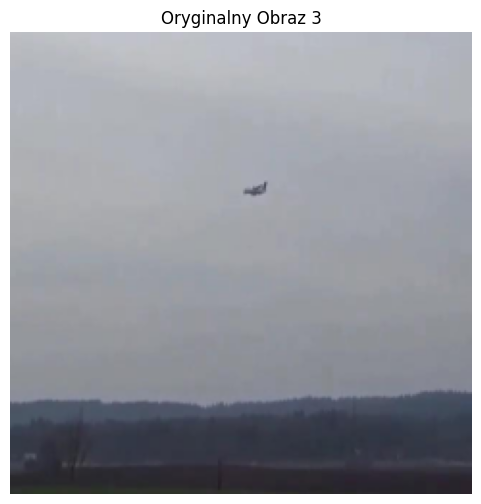

Obraz 3 - DeepDream:


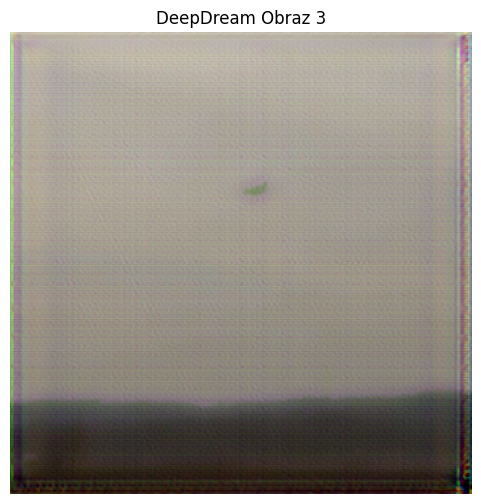

Obraz 4 - Oryginalny:


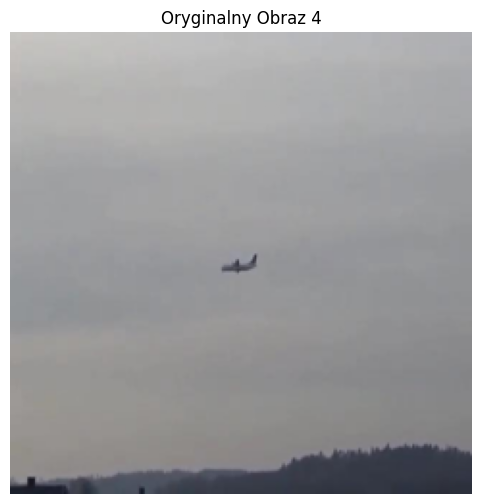

Obraz 4 - DeepDream:


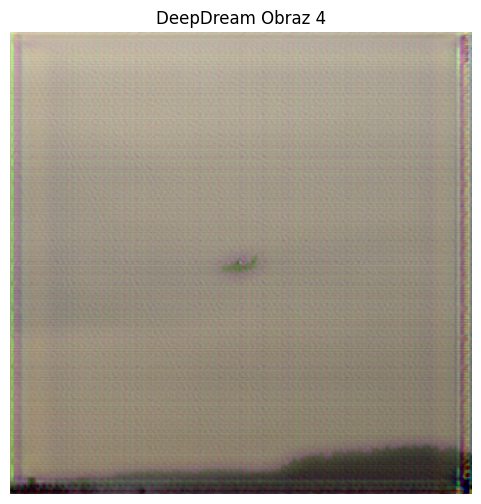

Obraz 5 - Oryginalny:


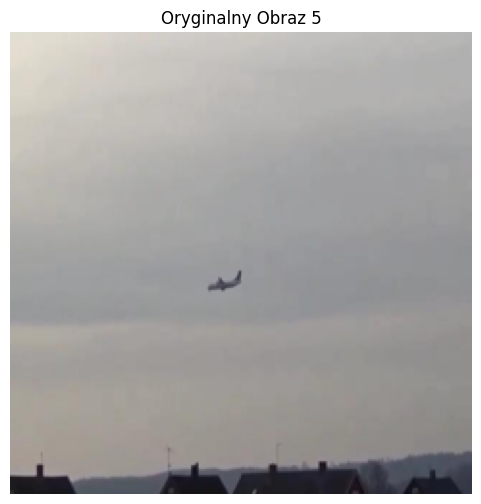

Obraz 5 - DeepDream:


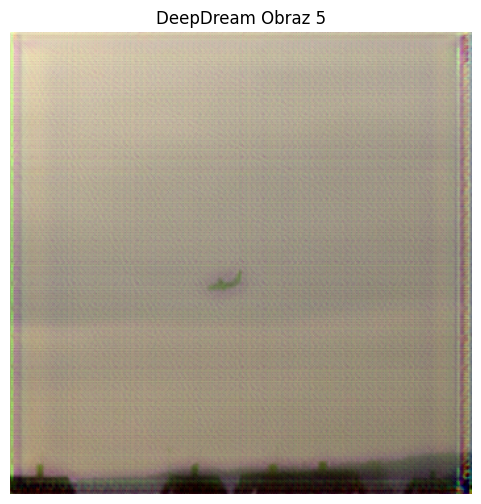

In [ ]:
model = keras.models.load_model("umir_model_3c_640.keras")



# ======================================
# 7. Wydobycie sub-modelu EfficientNetB0
#    (wewnętrznych warstw) z modelu
# ======================================
base_model = model.get_layer("efficientnetb0")  # pobranie sub-modelu
base_model.summary()

# ======================================
# 8. DeepDream - funkcje pomocnicze
# ======================================
layer_names = [
    "block1a_activation",  # niskopoziomowe wzory
    "block4a_activation",  # średniopoziomowe struktury
    "block7a_activation"   # zaawansowane semantyczne cechy
]

outputs = [base_model.get_layer(name).output for name in layer_names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

def calc_loss(img, dream_model, layer_weights=None):
    if layer_weights is None:
        layer_weights = [1.0] * len(dream_model.outputs)

    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = dream_model(img_batch)

    if not isinstance(layer_activations, list):
        layer_activations = [layer_activations]

    loss = 0
    for act, w in zip(layer_activations, layer_weights):
        loss += w * tf.reduce_mean(act)
    return loss

@tf.function
def gradient_ascent_step(img, dream_model, step_size=0.2):  # Zwiększenie step_size
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, dream_model)
    grads = tape.gradient(loss, img)

    # Wzmocnienie gradientów
    grads = grads * 5.0  # Mnożenie gradientów przez stałą
    grads = tf.math.l2_normalize(grads)  # Normalizacja
    img = img + step_size * grads  # Aktualizacja obrazu
    return img, loss


def run_deep_dream_simple(img,
                          dream_model,
                          steps=100,  # Więcej iteracji
                          step_size=0.2,  # Większy krok
                          octaves=5,  # Więcej oktaw
                          octave_scale=1.1):  # Mniejsza skala, więcej szczegółów
    img = tf.convert_to_tensor(img)
    original_shape = tf.shape(img)[:2]

    float_octave_size = tf.cast(original_shape, tf.float32)
    for octave in range(octaves):
        new_size = tf.cast(float_octave_size, tf.int32)
        img = tf.image.resize(img, new_size)

        for step in range(steps):
            img, loss = gradient_ascent_step(img, dream_model, step_size=step_size)

        float_octave_size = float_octave_size * octave_scale

    return img


# Wyświetlenie pierwszych 30 obrazków z ich DeepDream
print("Wyświetlanie pierwszych 30 obrazków z ich DeepDream:")
test_ds_iter = iter(test_ds)
example_batch, example_labels = next(test_ds_iter)

for i in range(min(5, len(example_batch))):
    sample_image = example_batch[i]
    sample_image = tf.image.convert_image_dtype(sample_image, dtype=tf.float32)

    # Wyświetlenie oryginalnego obrazu
    print(f"Obraz {i+1} - Oryginalny:")
    show_img(sample_image, title=f"Oryginalny Obraz {i+1}")

    # Wygenerowanie obrazu DeepDream
    dreamed_img = run_deep_dream_simple(
        img=sample_image,
        dream_model=dream_model,
        steps=60,          # Więcej iteracji
        step_size=0.2,      # Większy krok
        octaves=5,          # Więcej oktaw
        octave_scale=1.1    # Większa szczegółowość
    )

    # Wyświetlenie obrazu DeepDream
    print(f"Obraz {i+1} - DeepDream:")
    show_img(dreamed_img, title=f"DeepDream Obraz {i+1}")



In [ ]:
# =======================================
# 1. Importy i przygotowanie środowiska
# =======================================
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import randint
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler
import shutil
from zipfile import ZipFile

# =======================================
# 2. Pobranie przykładowego zbioru danych
# =======================================
path = kagglehub.dataset_download("cybersimar08/drone-detection")

print("Path to dataset files:", path)
train_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "images")
train_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "train", "labels")
valid_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "images")
valid_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "valid", "labels")
test_images_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "images")
test_labels_dir = os.path.join(path, "drone-detection-new.v5-new-train.yolov8", "test", "labels")

100%|██████████| 499M/499M [00:11<00:00, 45.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cybersimar08/drone-detection/versions/3


In [ ]:


IMG_SIZE = (240, 240)
NUM_CLASSES = 4

# ============================================
# 3. Funkcja do wczytywania obrazów i etykiet
# ============================================
# Etykiety: 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak (puste pliki)
def load_images_and_labels(image_dir, label_dir, img_size=(128, 128)):
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))
    images, labels = [], []

    for img_file, label_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("RGB").resize(img_size)
        images.append(np.asarray(image))

        label_path = os.path.join(label_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:  # Pusty plik = ptak
                class_id = 3
            else:
                class_id = int(lines[0].strip().split()[0])  # Samolot (0), dron (1), helikopter (2)
            labels.append(class_id)

    return np.array(images), np.array(labels)

# Wczytanie danych
train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir, IMG_SIZE)
valid_images, valid_labels = load_images_and_labels(valid_images_dir, valid_labels_dir, IMG_SIZE)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir, IMG_SIZE)

print(f"Obrazy treningowe: {len(train_images)}, walidacyjne: {len(valid_images)}, testowe: {len(test_images)}")

# =====================
# 4. Augmentacja danych
# =====================
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# ======================
# 5. Przygotowanie tf.data
# ======================
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label

def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Wyciągamy kształt wejścia z jednej próbki
for images_batch, labels_batch in train_ds.take(1):
    input_shape = images_batch[0].shape
    break

# =======================================
# 6. Definiujemy i trenujemy model (część A)
# =======================================
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
base_efficientnet.trainable = False  # Zamrożenie wag

inputs = keras.Input(shape=input_shape)
x = base_efficientnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Dodaj dropout
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Rozpoczęcie treningu modelu (część A).")
EPOCHS = 5
history_a = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS)
model.save('umir_model_3c_640.keras')

Obrazy treningowe: 10799, walidacyjne: 603, testowe: 596
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Rozpoczęcie treningu modelu (część A).
Epoch 1/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 200s 514ms/step - accuracy: 0.8528 - loss: 0.6236 - val_accuracy: 0.3002 - val_loss: 2.7749
Epoch 2/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 149s 439ms/step - accuracy: 0.7260 - loss: 1.0319 - val_accuracy: 0.3930 - val_loss: 2.7582
Epoch 3/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 202s 440ms/step - accuracy: 0.7472 - loss: 0.8680 - val_accuracy: 0.4710 - val_loss: 2.5349
Epoch 4/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 149s 440ms/step - accuracy: 0.7812 - loss: 0.7697 - val_accuracy: 0.5108 - val_loss: 2.4192
Epoch 5/5
338/338 ━━━━━━━━━━━━━━━━━━━━ 202s 440ms/step - accuracy: 0.8045 - loss: 0.7091 - val_accuracy: 0.5290 - val_loss: 2.2653


In [ ]:

results_a = model.evaluate(test_ds)
print(f"Test loss: {results_a[0]}, Test accuracy: {results_a[1]}")

y_pred = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Top-1 accuracy:", top_k_accuracy_score(y_true, y_pred, k=1))
print('Confusion Matrix:\n', confusion_matrix(y_true, np.argmax(y_pred, axis=1)))

# ======================================
# 7. Wydobycie sub-modelu EfficientNetB0
#    (wewnętrznych warstw) z modelu
# ======================================
base_model = model.get_layer("efficientnetb0")  # pobranie sub-modelu
base_model.summary()

# ======================================
# 8. DeepDream - funkcje pomocnicze
# ======================================

# Wybieramy kilka warstw z base_model do wizualizacji:
# (Możesz użyć base_model.summary() aby znaleźć odpowiednie nazwy warstw)
layer_names = [
    "block3a_activation",   # przykładowe nazwy
    "block5a_activation",
    "block7a_activation",
]

# Tworzymy sub-model (dream_model), który na wejściu ma obraz,
# a na wyjściu listę aktywacji tych wybranych warstw.
outputs = [base_model.get_layer(name).output for name in layer_names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

def calc_loss(img, dream_model, layer_weights=None):
    """
    Oblicza sumę (lub ważoną sumę) aktywacji w zadanych warstwach sub-modelu.
    """
    if layer_weights is None:
        layer_weights = [1.0] * len(dream_model.outputs)

    # Dodajemy wymiar batch = 1 do obrazu
    img_batch = tf.expand_dims(img, axis=0)

    # Przepuszczamy obraz przez submodel
    layer_activations = dream_model(img_batch)

    # Gdy submodel zwraca tylko 1 wyjście, w Keras może być pojedynczy tensor
    if not isinstance(layer_activations, list):
        layer_activations = [layer_activations]

    loss = 0
    for act, w in zip(layer_activations, layer_weights):
        # Obliczamy średnią aktywacji w wybranej warstwie
        loss += w * tf.reduce_mean(act)
    return loss

@tf.function
def gradient_ascent_step(img, dream_model, step_size=0.02):
    """
    Wykonuje 1 krok gradient ascent w celu zwiększenia straty (aktywacji).
    """
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, dream_model)
    # Obliczamy gradient względem obrazu (img)
    grads = tape.gradient(loss, img)
    # Normalizujemy gradient, żeby unikać zbyt dużych skoków
    grads = tf.math.l2_normalize(grads)
    # Modyfikujemy obraz "w górę" (ascent)
    img = img + step_size * grads
    return img, loss

def run_deep_dream_simple(img,
                          dream_model,
                          steps=100,        # zwiększona liczba kroków
                          step_size=0.02,   # zwiększona wielkość kroku
                          octaves=3,        # liczba oktaw
                          octave_scale=1.3):
    """
    Klasyczny DeepDream z oktawami. Najpierw dokonujemy serii kroków
    gradient ascent, potem skalujemy obraz w górę i powtarzamy.
    """
    img = tf.convert_to_tensor(img)
    original_shape = tf.shape(img)[:2]

    # Rozmiary kolejnych oktaw
    float_octave_size = tf.cast(original_shape, tf.float32)
    for octave in range(octaves):
        # Skalujemy obraz
        new_size = tf.cast(float_octave_size, tf.int32)
        img = tf.image.resize(img, new_size)

        # Wykonujemy serię kroków gradient ascent
        for step in range(steps):
            img, loss = gradient_ascent_step(img, dream_model, step_size=step_size)

        # Po zakończeniu danej oktawy zwiększamy rozmiar
        float_octave_size = float_octave_size * octave_scale

    return img

# ======================================
# 9. Demonstracja działania DeepDream
# ======================================
def show_img(img, title=""):
    """
    Funkcja pomocnicza do wyświetlania obrazu.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(img.numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()

# Pobieramy jeden obraz z test_ds (możesz wybrać dowolny z Twoich datasetów)
test_ds_iter = iter(test_ds)
example_batch, example_labels = next(test_ds_iter)
sample_image = example_batch[0]  # pierwszy obraz z batcha

# Konwertujemy na float w [0,1], jeśli jeszcze nie jest
sample_image = tf.image.convert_image_dtype(sample_image, dtype=tf.float32)

print("Obraz oryginalny:")
show_img(sample_image)

# Wykonaj DeepDream
dreamed_img = run_deep_dream_simple(
    img=sample_image,
    dream_model=dream_model,
    steps=100,        # zwiększona liczba kroków
    step_size=0.02,   # zwiększona wielkość kroku
    octaves=3,
    octave_scale=1.3
)

print("Obraz 'wyśniony' (DeepDream):")
show_img(dreamed_img, "DeepDream")

# =======================================================
# 10. Przetwarzanie całego zestawu danych i zapisywanie
# =======================================================
import os
from PIL import Image

# Folder do zapisywania wyników
output_dir = "deepdream_results"
os.makedirs(output_dir, exist_ok=True)

# Opcjonalnie, przygotuj podfoldery dla każdej klasy
class_names = {0: "samolot", 1: "dron", 2: "helikopter", 3: "ptak"}
for class_id in range(NUM_CLASSES):
    class_dir = os.path.join(output_dir, class_names[class_id])
    os.makedirs(class_dir, exist_ok=True)

# Funkcja do łączenia obrazów obok siebie
def concatenate_images(img1, img2):
    # Konwertujemy tensor do uint8
    img1 = tf.cast(img1 * 255.0, tf.uint8).numpy()
    img2 = tf.cast(img2 * 255.0, tf.uint8).numpy()
    # Tworzymy obiekty PIL Image
    pil_img1 = Image.fromarray(img1)
    pil_img2 = Image.fromarray(img2)
    # Ustal wysokość na maksymalną wysokość z obu obrazów
    total_width = pil_img1.width + pil_img2.width
    max_height = max(pil_img1.height, pil_img2.height)
    # Tworzymy nowy obraz z odpowiednimi wymiarami
    new_img = Image.new('RGB', (total_width, max_height))
    # Wklejamy oba obrazy obok siebie
    new_img.paste(pil_img1, (0,0))
    new_img.paste(pil_img2, (pil_img1.width, 0))
    return new_img

# Iteracja przez cały test_ds
for batch_images, batch_labels in test_ds:
    for img, label in zip(batch_images, batch_labels):
        # Konwertujemy na float w [0,1]
        img_float = tf.image.convert_image_dtype(img, dtype=tf.float32)

        # Uruchamiamy DeepDream
        dreamed = run_deep_dream_simple(
            img=img_float,
            dream_model=dream_model,
            steps=100,        # zwiększona liczba kroków
            step_size=0.02,   # zwiększona wielkość kroku
            octaves=3,
            octave_scale=1.3
        )

        # Łączymy obrazy
        combined = concatenate_images(img_float, dreamed)

        # Konwertujemy tensor do PIL Image
        combined_pil = combined

        # Opcjonalnie: dodajemy podpis z klasą
        class_name = class_names[int(label)]
        draw = ImageDraw.Draw(combined_pil)
        try:
            font = ImageFont.truetype("arial.ttf", 15)
        except:
            font = ImageFont.load_default()
        text = f"Oryginał vs DeepDream - {class_name}"
        text_position = (10, 10)
        # Dodanie półprzezroczystego tła dla tekstu
        text_size = draw.textsize(text, font=font)
        background = Image.new('RGBA', (text_size[0]+10, text_size[1]+10), (0,0,0,128))
        combined_pil.paste(background, (text_position[0], text_position[1]), background)
        draw.text(text_position, text, fill=(255, 255, 255, 255), font=font)

        # Tworzymy unikalną nazwę pliku
        # Możesz użyć np. unikalnego identyfikatora lub numeru indeksu
        # Tutaj używamy losowego numeru
        file_index = randint(100000, 999999)
        file_name = f"img_{file_index}.jpg"

        # Zapisywanie w odpowiednim folderze
        save_dir = os.path.join(output_dir, class_name)
        save_path = os.path.join(save_dir, file_name)
        combined_pil.save(save_path)

# ==============================================
# 11. Tworzenie pliku .zip do pobrania
# ==============================================
# Używamy biblioteki shutil do tworzenia archiwum .zip
shutil.make_archive("deepdream_results", 'zip', output_dir)

# Tworzenie linku do pobrania w Google Colab
from google.colab import files
files.download("deepdream_results.zip")


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - accuracy: 0.2238 - loss: 4.6111
Test loss: 2.6337714195251465, Test accuracy: 0.5100671052932739
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step
Top-1 accuracy: 0.5100671140939598
Confusion Matrix:
 [[  0  29  99   0]
 [  0 196  38   0]
 [  0   5 106   0]
 [  0  27  94   2]]


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

processing image0
processing image1
processing image2
processing image3
processing image4
processing image5
processing image6
processing image7
processing image8
processing image9
processing image10
processing image11
processing image12
processing image13
processing image14
processing image15
processing image16
processing image17
processing image18
processing image19
processing image20
processing image21
processing image22
processing image23
processing image24
processing image25
processing image26
processing image27
processing image28
processing image29
processing image30
processing image31
processing image32
processing image33
processing image34
processing image35
processing image36
processing image37
processing image38
processing image39
processing image40
processing image41
processing image42
processing image43
processing image44
processing image45
processing image46
processing image47
processing image48
processing image49
processing image50
processing image51
processing image52
pro

'/content/deepdream_results.zip'

##Podpunkt #4

Przygotować własny zbiór zdjęć dla wybranych kategorii (kilkadziesiąt zdjęć)oraz zanalizować wyniki klasyfikacji dla wszystkich wytrenowanych sieci z punktów 1 oraz 2. Do przygotowania zbioru można wykorzystać modele generatywne AI (np. Midjourney)

Katalog ai_dataset już istnieje, pomijam rozpakowywanie.


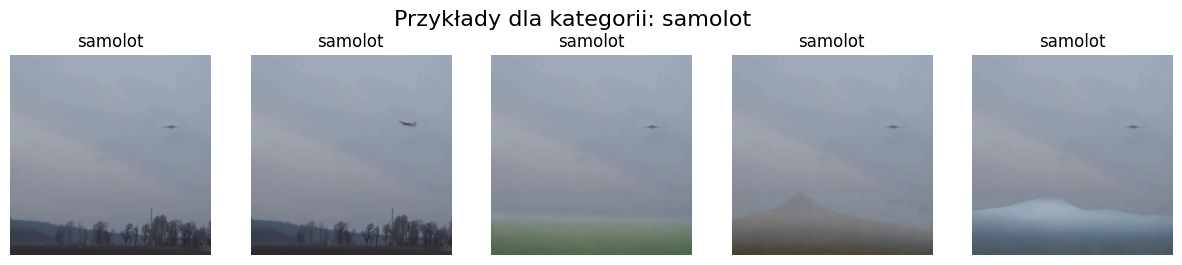

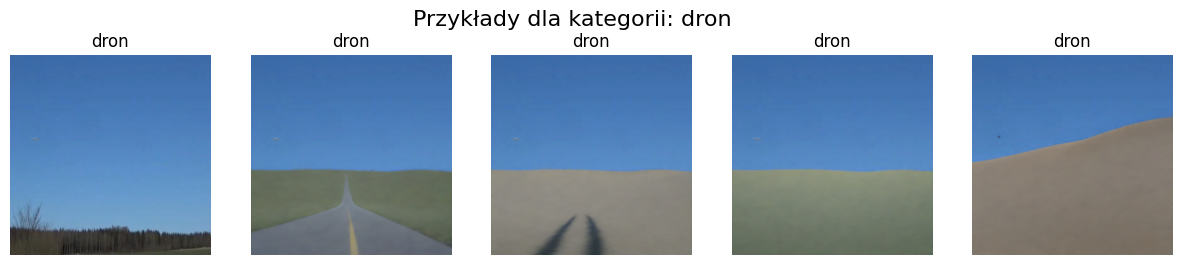

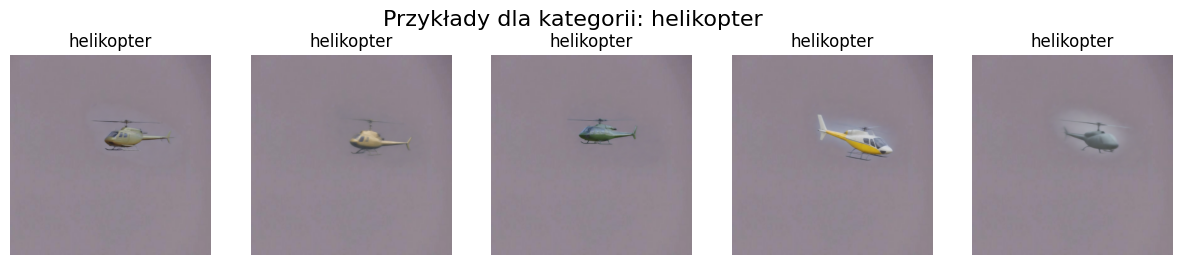

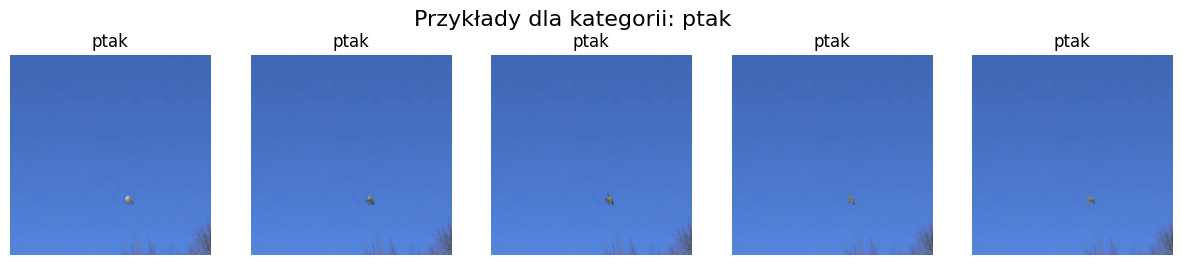

Custom dataset – liczba obrazów: 160

Ocenianie modelu: umir_model_zad1.keras
Loss: 4.3591  |  Accuracy: 0.3125
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
Top-1 Accuracy: 0.3125
Macierz pomyłek:
[[ 0  0 40  0]
 [ 1 10 29  0]
 [ 0  0 40  0]
 [ 0  0 40  0]]
Raport klasyfikacji:
              precision    recall  f1-score   support

     samolot       0.00      0.00      0.00        40
        dron       1.00      0.25      0.40        40
  helikopter       0.27      1.00      0.42        40
        ptak       0.00      0.00      0.00        40

    accuracy                           0.31       160
   macro avg       0.32      0.31      0.21       160
weighted avg       0.32      0.31      0.21       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Custom dataset – liczba obrazów: 160

Ocenianie modelu: umir_model_zad2a.keras
Loss: 1.5077  |  Accuracy: 0.3938
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
Top-1 Accuracy: 0.3937
Macierz pomyłek:
[[20  0 20  0]
 [17  5 18  0]
 [ 2  0 38  0]
 [ 0  0 40  0]]
Raport klasyfikacji:
              precision    recall  f1-score   support

     samolot       0.51      0.50      0.51        40
        dron       1.00      0.12      0.22        40
  helikopter       0.33      0.95      0.49        40
        ptak       0.00      0.00      0.00        40

    accuracy                           0.39       160
   macro avg       0.46      0.39      0.30       160
weighted avg       0.46      0.39      0.30       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Custom dataset – liczba obrazów: 160

Ocenianie modelu: umir_model_zad2b.keras
Loss: 2.4320  |  Accuracy: 0.2250
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
Top-1 Accuracy: 0.2250
Macierz pomyłek:
[[ 0  0 40  0]
 [ 0  2 38  0]
 [ 0  6 34  0]
 [ 0  0 40  0]]
Raport klasyfikacji:
              precision    recall  f1-score   support

     samolot       0.00      0.00      0.00        40
        dron       0.25      0.05      0.08        40
  helikopter       0.22      0.85      0.35        40
        ptak       0.00      0.00      0.00        40

    accuracy                           0.23       160
   macro avg       0.12      0.23      0.11       160
weighted avg       0.12      0.23      0.11       160



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Custom dataset – liczba obrazów: 160

Ocenianie modelu: umir_model_zad2c.keras
Loss: 1.3587  |  Accuracy: 0.3750
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Top-1 Accuracy: 0.3750
Macierz pomyłek:
[[ 1 24 13  2]
 [17 19  3  1]
 [ 0  0 40  0]
 [ 0  0 40  0]]
Raport klasyfikacji:
              precision    recall  f1-score   support

     samolot       0.06      0.03      0.03        40
        dron       0.44      0.47      0.46        40
  helikopter       0.42      1.00      0.59        40
        ptak       0.00      0.00      0.00        40

    accuracy                           0.38       160
   macro avg       0.23      0.38      0.27       160
weighted avg       0.23      0.38      0.27       160



In [9]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
import matplotlib.pyplot as plt

# Rozpakowywanie archiwum ai_dataset.zip (jeśli katalog nie istnieje)
zip_path = "ai_dataset.zip"
dataset_dir = "ai_dataset"

if not os.path.exists(dataset_dir):
    print(f"Rozpakowywanie {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Rozpakowywanie zakończone.")
else:
    print(f"Katalog {dataset_dir} już istnieje, pomijam rozpakowywanie.")

# Parametry
BATCH_SIZE = 32

# Słownik zgodny z etykietami:
# 0 - samolot, 1 - dron, 2 - helikopter, 3 - ptak
class_names = {0: "samolot", 1: "dron", 2: "helikopter", 3: "ptak"}

# Mapping folder_name -> label
folder_to_label = {
    "samolot": 0,
    "dron": 1,
    "helikopter": 2,
    "ptak": 3
}

# Słownik rozmiarów wejścia dla poszczególnych modeli
img_sizes = {
    "umir_model_zad1": (240, 240),
    "umir_model_zad2a": (224, 224),
    "umir_model_zad2b": (224, 224),
    "umir_model_zad2c": (224, 224)
}

def load_custom_test_dataset(dataset_dir, img_size=(128, 128)):
    """
    Wczytuje obrazy z katalogu dataset_dir, w którym obrazy są pogrupowane w podkatalogi
    odpowiadające nazwom klas.
    """
    images = []
    labels = []

    # Iterujemy po podkatalogach (każdy podkatalog to jedna klasa)
    for folder in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.isdir(folder_path):
            continue  # pomijamy pliki na najwyższym poziomie
        if folder not in folder_to_label:
            print(f"UWAGA: katalog '{folder}' nie znajduje się w mappingu, pomijam.")
            continue
        label = folder_to_label[folder]

        # Wczytujemy wszystkie obrazy z danego katalogu (sortujemy, aby kolejność była ustalona)
        for file in sorted(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            try:
                # Otwieramy obraz, konwertujemy do RGB i zmieniamy rozmiar
                image = Image.open(file_path).convert("RGB").resize(img_size)
                image = np.asarray(image)
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Nie udało się wczytać obrazu {file_path}: {e}")

    return np.array(images), np.array(labels)


def preprocess_custom(image, label):
    """
    Preprocessing: konwersja obrazu do float32 oraz zastosowanie preprocessingu (np. EfficientNet)
    """
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


def display_examples(dataset_dir, folder_to_label, num_examples=5):
    """
    Wyświetla po `num_examples` przykładowych obrazków z każdej kategorii znajdującej się w folder_to_label.
    """
    for folder in folder_to_label.keys():
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.isdir(folder_path):
            print(f"Katalog {folder_path} nie istnieje.")
            continue
        image_files = sorted(os.listdir(folder_path))
        if len(image_files) == 0:
            print(f"Brak obrazów w katalogu {folder_path}.")
            continue

        # Wybieramy min(num_examples, liczba dostępnych obrazów) obrazków
        examples = image_files[:num_examples]

        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Przykłady dla kategorii: {folder}", fontsize=16)

        for i, file in enumerate(examples):
            file_path = os.path.join(folder_path, file)
            try:
                image = Image.open(file_path).convert("RGB")
            except Exception as e:
                print(f"Nie udało się wczytać {file_path}: {e}")
                continue
            plt.subplot(1, num_examples, i+1)
            plt.imshow(image)
            plt.axis("off")
            plt.title(folder)

        plt.show()


# Wyświetlamy przykładowe obrazki dla każdej kategorii przed testowaniem modeli
display_examples(dataset_dir, folder_to_label, num_examples=5)


# Lista modeli do testowania – podaj ścieżki do plików .keras
model_paths = [
    "umir_model_zad1.keras",
    "umir_model_zad2a.keras",
    "umir_model_zad2b.keras",
    "umir_model_zad2c.keras"
]

# Testujemy każdy model
for model_path in model_paths:
    # Określamy rozmiar wejścia dla bieżącego modelu na podstawie nazwy pliku
    IMG_SIZE = img_sizes[model_path.split(".")[0]]

    # Wczytanie customowego zbioru testowego
    custom_images, custom_labels = load_custom_test_dataset(dataset_dir, IMG_SIZE)
    print(f"Custom dataset – liczba obrazów: {len(custom_images)}")

    # Tworzymy tf.data.Dataset
    custom_ds = tf.data.Dataset.from_tensor_slices((custom_images, custom_labels))
    custom_ds = custom_ds.map(preprocess_custom, num_parallel_calls=tf.data.AUTOTUNE)
    custom_ds = custom_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("\n" + "="*50)
    print(f"Ocenianie modelu: {model_path}")

    # Wczytanie modelu
    model = keras.models.load_model(model_path)

    # Ewaluacja – uzyskujemy loss oraz accuracy
    results = model.evaluate(custom_ds, verbose=0)
    print(f"Loss: {results[0]:.4f}  |  Accuracy: {results[1]:.4f}")

    # Predykcje
    y_pred_prob = model.predict(custom_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)
    # Łączymy etykiety z poszczególnych batchy
    y_true = np.concatenate([y for x, y in custom_ds], axis=0)

    # Obliczamy top-1 accuracy przy użyciu top_k_accuracy_score (k=1)
    top1 = top_k_accuracy_score(y_true, y_pred_prob, k=1)
    print(f"Top-1 Accuracy: {top1:.4f}")

    # Macierz pomyłek
    cm = confusion_matrix(y_true, y_pred)
    print("Macierz pomyłek:")
    print(cm)

    # Raport klasyfikacji – dla porządku wypisujemy nazwy klas wg indeksów 0,1,2,3
    target_names = [class_names[i] for i in sorted(class_names.keys())]
    print("Raport klasyfikacji:")
    print(classification_report(y_true, y_pred, target_names=target_names))
